# Analysis of spectral parameterization output (experiment 1)

In this notebook we're loading in the list of dataframes from all subjects. 
1. Remove trials from data per subject based on bad model fits "to_delete" column
2. Average parameters/output per subject
3. Save that in a new dataframe


In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import scipy as sp
# from scipy import stats
# from scipy.stats import wilcoxon
import pingouin as pg
import pickle as pkl

# from colourfulbirds import exp1_functionsforanalysis as dp
from colourfulbirds import exp1_functionsforplotting as dp_plot
from colourfulbirds.exp1_settings import SUB_THETA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

## Load matrices

In [2]:
# load list of dataframes for alpha, subs with theta, and subs without theta
alpha_name = 'alpha_all_dfs.pkl'
no_alpha_name = 'no_alpha_all_dfs.pkl'
theta_name = 'theta_all_dfs.pkl'
no_theta_name = 'no_theta_all_dfs.pkl'

path = '../saved_files/fooof_results/exp1_output/main_analysis/'
with open (path + alpha_name, 'rb') as f:
    dfs_alpha = pkl.load(f)

with open (path + no_alpha_name, 'rb') as f:
    dfs_no_alpha = pkl.load(f)

with open (path + theta_name, 'rb') as f:
    dfs_theta = pkl.load(f)

with open (path + no_theta_name, 'rb') as f:
    dfs_no_theta = pkl.load(f)


# If I get the lists of dataframes right, this becomes redundant
exp1_theta_avgp = np.load('../saved_files/fooof_results/exp1_output/main_analysis/theta_exp1_avg_perf.npy')
exp1_no_theta_avgp = np.load('../saved_files/fooof_results/exp1_output/main_analysis/no_theta_exp1_avg_perf.npy')

# import list of included ppn numbers
alpha_ppns_dic = np.load('../saved_files/fooof_results/exp1_output/main_analysis/alpha_exp1_ppns.npy', allow_pickle=True)
theta_ppns_dic = np.load('../saved_files/fooof_results/exp1_output/main_analysis/theta_exp1_ppns.npy', allow_pickle=True)
no_theta_ppns_dic = np.load('../saved_files/fooof_results/exp1_output/main_analysis/no_theta_exp1_ppns.npy', allow_pickle=True)

# Now we need to also include the gender data from another file and match that with the sub_ids from 'included'
dem = pd.read_excel('../../Experiment_1/E1_Demographics.xlsx')


In [3]:
# I was an idiot before and named a column "set_size". But pandas doesn't like that, so I'm renaming
# it to "set_size" <-- renaming it in the original script and running over it again, so I don't
# have to rename everything in here
# For whatever reason, the no-theta group is very stubborn in the script not adjusting
df_store = []
for idx in np.arange(0, len(dfs_no_theta)):
    df_temp = dfs_no_theta[idx]
    df_temp = df_temp.rename(columns={'set-size': 'set_size'})
    df_store.append(df_temp)

dfs_no_theta = df_store


In [4]:
alpha_ppns_dic

array({'included': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 30, 31], 'with_peak': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31], 'wo_peak': [], 'rejected': [], 'rejected_r2': [15, 18, 26, 28]},
      dtype=object)

In [5]:
theta_ppns_dic

array({'considered': array([ 1,  5,  7, 10, 11, 16, 17, 18, 19, 22, 23, 28]), 'included': [1, 5, 7, 10, 11, 16, 17, 19, 22, 23], 'rejected': [18, 28], 'rejected_r2': []},
      dtype=object)

In [6]:
no_theta_ppns_dic

array({'considered': array([ 2,  3,  4,  6,  8,  9, 12, 13, 14, 15, 20, 21, 24, 25, 26, 29, 30,
       31]), 'included': [2, 3, 4, 6, 8, 9, 12, 13, 14, 20, 21, 25, 26, 29, 30, 31], 'rejected': [15], 'rejected_r2': []},
      dtype=object)

## Now we will first clean the dataframes and combine them into 1 for the average per subject
1. Delete trials with bad fits
2. Average parameters for subject
3. Create final dataframe for analyses


In [7]:
# We have to loop over 4 dataframes: alpha/theta * present/absent
# dfs_input = [dfs_alpha, dfs_no_alpha, dfs_theta, dfs_no_theta]

keep_cols_theta = ['sub_id', 'trial_n', 'set_size', 'bas_ret_diff', 'exponent', 'offset', 
    'power', 'cf', 'peak_perc', 'bandpower', 'auc', 'auc_log_osc', 'auc_lin_osc', 'r2s', 'wm_capacity', 'osc_presence']
keep_cols_alpha = ['sub_id', 'trial_n', 'set_size', 'lateralization', 'bas_ret_diff', 'exponent', 
    'offset', 'power', 'cf', 'peak_perc', 'bandpower', 'auc', 'auc_log_osc', 'auc_lin_osc', 'r2s', 'wm_capacity', 'osc_presence']

# Loop over THETA bands and groups having oscillation or not
for idx, df in enumerate([dfs_theta, dfs_no_theta]):

    df_avg = []

    # Loop over subjects within one list of dfs
    for sub in np.arange(0, len(df)):
        
        df_temp = df[sub]

        # Delete bad trials from data
        df_include = df_temp.query('to_exclude == False')[keep_cols_theta]

        # Take the average of each setsize/condition, and time point or the difference 
        # Keep in mind that the "theta_presence" column is not True/False anymore, but 1.0 or 0
        df_sub_avg = pd.DataFrame(df_include.groupby(['set_size', 'bas_ret_diff'], 
                        as_index=False)[keep_cols_theta].mean())
        
        # Create list of pds
        df_avg.append(df_sub_avg)

    # Now concatenate the pds so all subs and conditions are as rows
    if idx == 0:
        df_theta_avg = pd.concat(df_avg, axis=0)
    else:
        df_no_theta_avg = pd.concat(df_avg, axis=0)


# There are no subjects without alpha peaks in this experiment:
df_avg = []

# Loop over subjects within one list of dfs
for sub in np.arange(0, len(dfs_alpha)):
    
    df_temp = dfs_alpha[sub]

    # Delete bad trials from data
    df_include = df_temp.query('to_exclude == False')[keep_cols_alpha]

    # Take the average of each setsize/condition, and time point or the difference 
    # Keep in mind that the "theta_presence" column is not True/False anymore, but 1.0 or 0
    df_sub_avg = pd.DataFrame(df_include.groupby(['set_size', 'lateralization', 'bas_ret_diff'], 
                        as_index=False)[keep_cols_alpha].mean())
    
    # Create list of pds
    df_avg.append(df_sub_avg)

# Now concatenate the pds so all subs and conditions are as rows

df_alpha_avg = pd.concat(df_avg, axis=0)



# Uncomment code below to run Loop if there would be subjects without alpha peaks:
# Loop over ALPHA bands and groups having oscillation or not
# for idx, df in enumerate([dfs_alpha, dfs_no_alpha]):

#     df_avg = []

#     # Loop over subjects within one list of dfs
#     for sub in np.arange(0, len(df)):
        
#         df_temp = df[sub]

#         # Delete bad trials from data
#         df_include = df_temp.query('to_exclude == False')[keep_cols_alpha]

#         # Take the average of each setsize/condition, and time point or the difference 
#         # Keep in mind that the "theta_presence" column is not True/False anymore, but 1.0 or 0
#         df_sub_avg = pd.DataFrame(df_include.groupby(['set_size', 'lateralization', 'bas_ret_diff'], 
#                             as_index=False)[keep_cols_alpha].mean())
        
#         # Create list of pds
#         df_avg.append(df_sub_avg)

#     # Now concatenate the pds so all subs and conditions are as rows
#     if idx == 0:
#         df_alpha_avg = pd.concat(df_avg, axis=0)
#     else:
#         df_no_alpha_avg = pd.concat(df_avg, axis=0)



In [8]:
# Save theta dataframe of people who do have theta oscillations for comparison with other experiment
df_theta_avg.to_csv('../saved_files/combined_exps/exp1_theta')
df_alpha_avg.to_csv('../saved_files/combined_exps/exp1_alpha')

In [9]:
df_alpha_avg

,lateralization,bas_ret_diff,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
0,contra,bas,1.0,93.051948,1.0,1.560984,1.134809,1.611939,9.404664,4.519774,16.579791,66.838097,4.388604,59.178313,0.837645,1.903654,1.0
1,contra,diff,1.0,93.051948,1.0,0.028525,-0.047891,-0.125046,0.086155,4.519774,-4.440927,-16.648935,-0.154460,-14.860490,NaN,1.903654,1.0
2,contra,ret,1.0,93.051948,1.0,1.589509,1.086918,1.486893,9.506634,9.039548,12.138864,50.189161,4.234144,44.317823,0.841842,1.903654,1.0
3,ipsi,bas,1.0,93.051948,1.0,1.578540,1.141038,1.619429,9.541522,3.389831,15.867134,63.986323,4.465666,56.615605,0.853810,1.903654,1.0
4,ipsi,diff,1.0,93.051948,1.0,-0.038647,-0.106407,-0.059296,-0.001724,2.824859,-3.508912,-11.748614,-0.188172,-10.409327,NaN,1.903654,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,contra,diff,31.0,61.028037,6.0,-0.156636,-0.211519,0.192958,0.140763,-16.666667,0.166910,1.839986,0.444537,2.088678,NaN,1.951791,1.0
14,contra,ret,31.0,61.028037,6.0,1.343473,1.176085,0.999701,9.782385,12.698413,6.733688,28.873228,2.871617,23.510267,0.787643,1.951791,1.0
15,ipsi,bas,31.0,61.028037,6.0,1.444752,1.319975,0.797687,9.546508,26.984127,6.273433,25.985470,2.479565,20.517324,0.763505,1.951791,1.0
16,ipsi,diff,31.0,61.028037,6.0,-0.061310,-0.101399,0.155876,0.014791,-4.761905,0.699501,4.708453,0.415637,4.565931,NaN,1.951791,1.0


# Analyses

1. Check assumptions - mostly sphericity for 2-way repeated measures anova
2. Perform statistical test
3. If permitted, perform post-hoc tests

## Alpha Analyses

In [10]:
# preparing the dataframe
all_cols = df_alpha_avg.columns
df_alpha_avg_diff = df_alpha_avg.query('bas_ret_diff == "diff"')[all_cols]
df_alpha_avg_ret = df_alpha_avg.query('bas_ret_diff == "ret"')[all_cols]
df_alpha_avg_bas = df_alpha_avg.query('bas_ret_diff == "bas"')[all_cols]

### ALPHA - AMPLITUDE (APERIODIC ADJUSTED POWER)

In [11]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['power'].describe()

count      mean       std       min  \
bas_ret_diff lateralization set_size                                        
bas          contra         1.0        26.0  1.159647  0.408505  0.409582   
                            3.0        26.0  1.168757  0.406622  0.491409   
                            6.0        26.0  1.151043  0.415456  0.397910   
             ipsi           1.0        26.0  1.204750  0.406319  0.515517   
                            3.0        26.0  1.205427  0.410541  0.503013   
                            6.0        26.0  1.209682  0.406103  0.479651   
diff         contra         1.0        26.0 -0.031633  0.148385 -0.303692   
                            3.0        26.0 -0.125284  0.176242 -0.494807   
                            6.0        26.0 -0.141662  0.178617 -0.610274   
             ipsi           1.0        26.0 -0.049703  0.126573 -0.273987   
                            3.0        26.0 -0.080693  0.196350 -0.440244   
                            6.0        26.0 -0.126827  0.164432 -0.428267   
ret          contra         1.0        26.0  1.128014  0.423494  0.463746   
                            3.0        26.0  1.043473  0.355378  0.452565   
                            6.0        26.0  1.009381  0.344703  0.451475   
             ipsi           1.0        26.0  1.155048  0.413272  0.608434   
                            3.0        26.0  1.124734  0.391067  0.467233   
                            6.0        26.0  1.082855  0.378506  0.496649   

                                           25%       50%       75%       max  
bas_ret_diff lateralization set_size                                          
bas          contra         1.0       0.810140  1.099708  1.436950  1.930179  
                            3.0       0.855868  1.091134  1.450561  1.954002  
                            6.0       0.816669  1.089870  1.486195  1.907042  
             ipsi           1.0       0.899290  1.168096  1.496054  1.917055  
                            3.0       0.862642  1.198298  1.507321  1.948650  
                            6.0       0.925632  1.154548  1.492074  1.928758  
diff         contra         1.0      -0.118433 -0.015887  0.045036  0.405867  
                            3.0      -0.259449 -0.143088  0.003721  0.265434  
                            6.0      -0.267983 -0.139315 -0.044855  0.192958  
             ipsi           1.0      -0.132196 -0.041494  0.028022  0.167636  
                            3.0      -0.227259 -0.064972  0.078403  0.255223  
                            6.0      -0.242358 -0.110488 -0.014320  0.201453  
ret          contra         1.0       0.769777  1.074408  1.468810  1.906244  
                            3.0       0.763301  0.990518  1.327510  1.727378  
                            6.0       0.787034  0.942082  1.311960  1.689482  
             ipsi           1.0       0.783698  1.191163  1.451483  1.981905  
                            3.0       0.770718  1.127983  1.402297  1.945543  
                            6.0       0.752484  1.098548  1.351525  1.794980

In [12]:
df_alpha_avg.groupby(['bas_ret_diff', 'set_size'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
bas          1.0        52.0  1.182199  0.404041  0.409582  0.841394   
             3.0        52.0  1.187092  0.404984  0.491409  0.856295   
             6.0        52.0  1.180362  0.407835  0.397910  0.831260   
diff         1.0        52.0 -0.040668  0.136857 -0.303692 -0.127593   
             3.0        52.0 -0.102988  0.186096 -0.494807 -0.234567   
             6.0        52.0 -0.134244  0.170145 -0.610274 -0.250499   
ret          1.0        52.0  1.141531  0.414517  0.463746  0.777042   
             3.0        52.0  1.084104  0.372235  0.452565  0.756682   
             6.0        52.0  1.046118  0.360347  0.451475  0.771759   

                            50%       75%       max  
bas_ret_diff set_size                                
bas          1.0       1.124650  1.477447  1.930179  
             3.0       1.131926  1.483656  1.954002  
             6.0       1.125568  1.497719  1.928758  
diff         1.0      -0.031161  0.038731  0.405867  
             3.0      -0.125211  0.010162  0.265434  
             6.0      -0.125482 -0.018033  0.201453  
ret          1.0       1.113599  1.479152  1.981905  
             3.0       1.056338  1.373199  1.945543  
             6.0       0.985034  1.349308  1.794980

In [13]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           78.0  1.159816  0.404915  0.397910  0.831158   
             ipsi             78.0  1.206620  0.402336  0.479651  0.893956   
diff         contra           78.0 -0.099526  0.173124 -0.610274 -0.221498   
             ipsi             78.0 -0.085741  0.165875 -0.440244 -0.217838   
ret          contra           78.0  1.060290  0.374608  0.451475  0.763301   
             ipsi             78.0  1.120879  0.390524  0.467233  0.765965   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          1.097626  1.458233  1.954002  
             ipsi            1.177454  1.503597  1.948650  
diff         contra         -0.097105  0.020615  0.405867  
             ipsi           -0.057617  0.006049  0.255223  
ret          contra          0.985034  1.359125  1.906244  
             ipsi            1.120955  1.402297  1.981905

In [14]:
df_alpha_avg.groupby(['bas_ret_diff'])['power'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,1.183218,0.403008,0.397910,0.851370,1.124650,1.497293,1.954002
diff,156.0,-0.092633,0.169132,-0.610274,-0.220054,-0.084930,0.017311,0.405867
ret,156.0,1.090584,0.382621,0.451475,0.759531,1.069293,1.372429,1.981905


In [15]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='power', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='power', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='power', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=True, W=0.78327512606537, chi2=5.862510490165121, dof=2, pval=0.053330053825306374)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.8991106270932853, chi2=2.552380712643186, dof=2, pval=0.27909854369300785)


In [16]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='power', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,0.236034,2,50,0.118017,6.252480,0.003770,0.006727,0.200063,0.821878
1,lateralization,0.007411,1,25,0.007411,1.167190,0.290292,0.290292,0.044605,1.000000
2,set_size * lateralization,0.025543,2,50,0.012771,2.952149,0.061393,0.067058,0.105614,0.908356


In [17]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='power', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,2.102151,25.0,two-sided,0.045779,1.354,0.394681
1,set_size,-,1.0,6.0,True,True,3.101133,25.0,two-sided,0.004729,8.918,0.643808
2,set_size,-,3.0,6.0,True,True,1.585774,25.0,two-sided,0.125360,0.625,0.181251
3,lateralization,-,contra,ipsi,True,True,-1.080366,25.0,two-sided,0.290292,0.35,-0.097399
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.886805,25.0,two-sided,0.383636,0.296,0.131025
5,set_size * lateralization,3.0,contra,ipsi,True,True,-3.198886,25.0,two-sided,0.003726,10.945,-0.239007
6,set_size * lateralization,6.0,contra,ipsi,True,True,-0.635755,25.0,two-sided,0.530713,0.249,-0.086416


### ALPHA - LOG AUC (APERIODIC ADJUSTED POWER)

In [18]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['auc_log_osc'].describe()

count      mean       std       min  \
bas_ret_diff lateralization set_size                                        
bas          contra         1.0        26.0  3.194161  1.105029  1.102357   
                            3.0        26.0  3.210235  1.126670  1.170260   
                            6.0        26.0  3.153582  1.128071  1.010997   
             ipsi           1.0        26.0  3.324419  1.107735  1.306365   
                            3.0        26.0  3.306640  1.108472  1.303518   
                            6.0        26.0  3.324752  1.131073  1.291716   
diff         contra         1.0        26.0 -0.113650  0.324355 -0.662278   
                            3.0        26.0 -0.316577  0.458188 -1.261623   
                            6.0        26.0 -0.414824  0.408440 -1.245136   
             ipsi           1.0        26.0 -0.169245  0.286153 -0.687285   
                            3.0        26.0 -0.250817  0.520594 -1.317628   
                            6.0        26.0 -0.366878  0.442897 -1.003618   
ret          contra         1.0        26.0  3.080511  1.142460  1.290554   
                            3.0        26.0  2.893659  1.026848  0.953771   
                            6.0        26.0  2.738758  1.003697  0.893846   
             ipsi           1.0        26.0  3.155173  1.120706  1.610907   
                            3.0        26.0  3.055823  1.104466  0.982627   
                            6.0        26.0  2.957874  1.063574  1.127913   

                                           25%       50%       75%       max  
bas_ret_diff lateralization set_size                                          
bas          contra         1.0       2.471565  3.030845  3.867144  5.504277  
                            3.0       2.447481  3.060785  3.935567  5.549802  
                            6.0       2.316878  2.970481  3.902069  5.417754  
             ipsi           1.0       2.548779  3.278373  4.158410  5.519112  
                            3.0       2.555091  3.174843  4.071260  5.501010  
                            6.0       2.497895  3.236919  4.168774  5.389713  
diff         contra         1.0      -0.293681 -0.082302  0.053823  0.746332  
                            3.0      -0.685404 -0.231833 -0.119407  0.564195  
                            6.0      -0.720404 -0.384165 -0.067118  0.444537  
             ipsi           1.0      -0.361463 -0.170966 -0.005406  0.365337  
                            3.0      -0.673882 -0.254639  0.204001  0.583548  
                            6.0      -0.778237 -0.421473 -0.047468  0.579452  
ret          contra         1.0       2.003251  3.093455  3.869096  5.451556  
                            3.0       2.043710  2.755864  3.623458  4.940697  
                            6.0       2.029183  2.547117  3.552104  4.814869  
             ipsi           1.0       2.139822  3.216253  3.946548  5.384062  
                            3.0       1.995314  3.037932  3.843825  5.389192  
                            6.0       2.061750  2.866800  3.806007  4.948246

In [19]:
df_alpha_avg.groupby(['bas_ret_diff', 'set_size'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
bas          1.0        52.0  3.259290  1.097454  1.102357  2.485576   
             3.0        52.0  3.258438  1.107667  1.170260  2.512386   
             6.0        52.0  3.239167  1.121778  1.010997  2.424917   
diff         1.0        52.0 -0.141448  0.304136 -0.687285 -0.340466   
             3.0        52.0 -0.283697  0.486687 -1.317628 -0.679910   
             6.0        52.0 -0.390851  0.422514 -1.245136 -0.731125   
ret          1.0        52.0  3.117842  1.121120  1.290554  2.099644   
             3.0        52.0  2.974741  1.059026  0.953771  2.023991   
             6.0        52.0  2.848316  1.029840  0.893846  2.023326   

                            50%       75%       max  
bas_ret_diff set_size                                
bas          1.0       3.124560  4.094689  5.519112  
             3.0       3.085281  4.054764  5.549802  
             6.0       3.183437  4.151141  5.417754  
diff         1.0      -0.123853  0.051589  0.746332  
             3.0      -0.231833  0.065675  0.583548  
             6.0      -0.412613 -0.049050  0.579452  
ret          1.0       3.179248  3.906930  5.451556  
             3.0       2.903018  3.770606  5.389192  
             6.0       2.816624  3.653616  4.948246

In [20]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           78.0  3.185993  1.105593  1.010997  2.387553   
             ipsi             78.0  3.318604  1.101259  1.291716  2.540753   
diff         contra           78.0 -0.281684  0.415227 -1.261623 -0.634284   
             ipsi             78.0 -0.262313  0.430032 -1.317628 -0.628413   
ret          contra           78.0  2.904309  1.054974  0.893846  2.008159   
             ipsi             78.0  3.056290  1.085210  0.982627  2.047698   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          3.060785  3.915513  5.549802  
             ipsi            3.236919  4.168774  5.519112  
diff         contra         -0.203431 -0.004355  0.746332  
             ipsi           -0.200188  0.014176  0.583548  
ret          contra          2.796161  3.687564  5.451556  
             ipsi            2.969506  3.854198  5.389192

In [21]:
df_alpha_avg.groupby(['bas_ret_diff'])['auc_log_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,3.252298,1.101872,1.010997,2.450082,3.124560,4.094689,5.549802
diff,156.0,-0.271999,0.421440,-1.317628,-0.635494,-0.200188,0.001401,0.746332
ret,156.0,2.980300,1.069462,0.893846,2.036601,2.891539,3.809609,5.451556


In [22]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_log_osc', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_log_osc', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_log_osc', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=False, W=0.7461899084865147, chi2=7.02660341181107, dof=2, pval=0.0297983663958221)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.9632794531573435, chi2=0.8978812580760126, dof=2, pval=0.638303994290994)


In [23]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='auc_log_osc', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,1.627929,2,50,0.813965,6.554849,0.002964,0.005973,0.207729,0.797569
1,lateralization,0.014633,1,25,0.014633,0.622316,0.437606,0.437606,0.024288,1.000000
2,set_size * lateralization,0.111649,2,50,0.055824,3.509066,0.037491,0.039312,0.123086,0.964580


In [24]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='auc_log_osc', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,1.817285,25.0,two-sided,0.081180,0.866,0.356205
1,set_size,-,1.0,6.0,True,True,3.267830,25.0,two-sided,0.003145,12.667,0.697835
2,set_size,-,3.0,6.0,True,True,2.198193,25.0,two-sided,0.037412,1.591,0.239223
3,lateralization,-,contra,ipsi,True,True,-0.788870,25.0,two-sided,0.437606,0.275,-0.054756
4,set_size * lateralization,1.0,contra,ipsi,True,True,1.697166,25.0,two-sided,0.102082,0.728,0.181771
5,set_size * lateralization,3.0,contra,ipsi,True,True,-1.863558,25.0,two-sided,0.074171,0.928,-0.134098
6,set_size * lateralization,6.0,contra,ipsi,True,True,-1.089120,25.0,two-sided,0.286489,0.353,-0.112545


### ALPHA - LINEAR AUC (APERIODIC ADJUSTED POWER)

In [25]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['auc_lin_osc'].describe()

count       mean        std         min  \
bas_ret_diff lateralization set_size                                            
bas          contra         1.0        26.0  34.487279  37.257375    2.701929   
                            3.0        26.0  34.528750  36.644653    2.962812   
                            6.0        26.0  33.747249  37.379536    2.447853   
             ipsi           1.0        26.0  37.316150  37.348528    3.737561   
                            3.0        26.0  36.505233  37.887915    3.256032   
                            6.0        26.0  36.779367  35.723316    3.267294   
diff         contra         1.0        26.0  -4.795330  11.172927  -31.484895   
                            3.0        26.0 -13.046047  22.087958 -100.918523   
                            6.0        26.0 -15.206459  24.843367 -118.965751   
             ipsi           1.0        26.0  -5.605552  10.659478  -38.760673   
                            3.0        26.0  -9.901897  22.148219  -94.779689   
                            6.0        26.0 -14.480640  22.416539  -99.953764   
ret          contra         1.0        26.0  29.691949  31.847355    3.548774   
                            3.0        26.0  21.482703  18.458287    2.112250   
                            6.0        26.0  18.540790  14.892988    2.275056   
             ipsi           1.0        26.0  31.710598  31.553209    4.684040   
                            3.0        26.0  26.603336  22.919262    2.137972   
                            6.0        26.0  22.298727  17.990676    2.545311   

                                            25%        50%        75%  \
bas_ret_diff lateralization set_size                                    
bas          contra         1.0       12.616933  24.425783  42.762663   
                            3.0       12.941465  24.966154  44.372362   
                            6.0       12.579993  23.656981  45.439728   
             ipsi           1.0       15.533921  28.875245  51.486236   
                            3.0       14.260008  26.039172  46.318881   
                            6.0       13.377466  25.782677  53.555128   
diff         contra         1.0       -9.052446  -2.790344   0.415617   
                            3.0      -16.709467  -5.231365   0.340798   
                            6.0      -18.345003  -6.784661  -2.002409   
             ipsi           1.0      -10.689169  -4.431596   0.531113   
                            3.0      -14.444405  -5.322105   1.011480   
                            6.0      -20.325542  -6.173455  -1.069137   
ret          contra         1.0        9.436982  21.588235  43.280857   
                            3.0        8.222466  16.283988  29.136628   
                            6.0        7.720278  16.517174  23.326872   
             ipsi           1.0       10.549195  22.436042  41.995023   
                            3.0        8.171188  23.434809  33.588865   
                            6.0        7.120532  19.937905  29.739140   

                                             max  
bas_ret_diff lateralization set_size              
bas          contra         1.0       192.769688  
                            3.0       186.859942  
                            6.0       191.756748  
             ipsi           1.0       191.674224  
                            3.0       192.358060  
                            6.0       177.903867  
diff         contra         1.0        26.509248  
                            3.0         2.806668  
                            6.0         2.908883  
             ipsi           1.0        19.228163  
                            3.0        17.715177  
                            6.0        10.416687  
ret          contra         1.0       161.284793  
                            3.0        85.941420  
                            6.0        72.790997  
             ipsi           1.0       152.913550  
                            3.0       

In [26]:
df_alpha_avg.groupby(['bas_ret_diff', 'set_size'])['auc_lin_osc'].describe()

count       mean        std         min        25%  \
bas_ret_diff set_size                                                       
bas          1.0        52.0  35.901714  36.963057    2.701929  13.553815   
             3.0        52.0  35.516992  36.917742    2.962812  13.075618   
             6.0        52.0  35.263308  36.232946    2.447853  12.637075   
diff         1.0        52.0  -5.200441  10.819375  -38.760673 -10.502607   
             3.0        52.0 -11.473972  21.957647 -100.918523 -15.838158   
             6.0        52.0 -14.843550  23.430833 -118.965751 -19.846677   
ret          1.0        52.0  30.701274  31.404836    3.548774   9.695561   
             3.0        52.0  24.043019  20.765212    2.112250   8.111430   
             6.0        52.0  20.419758  16.461616    2.275056   7.210198   

                             50%        75%         max  
bas_ret_diff set_size                                    
bas          1.0       26.306280  47.212186  192.769688  
             3.0       26.039172  45.461299  192.358060  
             6.0       25.643530  47.508181  191.756748  
diff         1.0       -3.753636   0.527306   26.509248  
             3.0       -5.231365   0.756833   17.715177  
             6.0       -6.455525  -1.674690   10.416687  
ret          1.0       21.588235  42.590894  161.284793  
             3.0       20.604777  29.525417   97.578371  
             6.0       18.483021  24.952638   77.950103

In [27]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['auc_lin_osc'].describe()

count       mean        std         min  \
bas_ret_diff lateralization                                            
bas          contra           78.0  34.254426  36.612105    2.447853   
             ipsi             78.0  36.866917  36.515945    3.256032   
diff         contra           78.0 -11.015946  20.486755 -118.965751   
             ipsi             78.0  -9.996030  19.303136  -99.953764   
ret          contra           78.0  23.238480  23.119072    2.112250   
             ipsi             78.0  26.870887  24.776514    2.137972   

                                   25%        50%        75%         max  
bas_ret_diff lateralization                                               
bas          contra          12.565707  24.625049  44.641525  192.769688  
             ipsi            13.724867  26.271786  52.504566  192.358060  
diff         contra         -14.618910  -5.231365  -0.175808   26.509248  
             ipsi           -15.479252  -4.653310  -0.153216   19.228163  
ret          contra           8.511989  18.854207  29.136628  161.284793  
             ipsi             8.627697  20.451593  35.005017  152.913550

In [28]:
df_alpha_avg.groupby(['bas_ret_diff'])['auc_lin_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,35.560671,36.469469,2.447853,12.651329,25.918541,46.967272,192.769688
diff,156.0,-10.505988,19.846031,-118.965751,-14.883059,-4.724799,-0.139946,26.509248
ret,156.0,25.054684,23.954102,2.112250,8.504297,19.715542,30.941515,161.284793


In [29]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=False, W=0.19465514888678173, chi2=39.276618077998265, dof=2, pval=2.959311967626155e-09)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.8051612158909638, chi2=5.2011060822489, dof=2, pval=0.07423251322748119)


In [30]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,2490.81386,2,50,1245.406930,6.881459,0.002291,0.011961,0.215845,0.553911
1,lateralization,40.56890,1,25,40.568900,1.410208,0.246183,0.246183,0.053396,1.000000
2,set_size * lateralization,103.32749,2,50,51.663745,2.913614,0.063548,0.074025,0.104380,0.836933


In [31]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='auc_lin_osc', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,2.109452,25.0,two-sided,0.045089,1.371,0.365438
1,set_size,-,1.0,6.0,True,True,2.884437,25.0,two-sided,0.007956,5.725,0.532999
2,set_size,-,3.0,6.0,True,True,3.631572,25.0,two-sided,0.001268,27.928,0.148606
3,lateralization,-,contra,ipsi,True,True,-1.187522,25.0,two-sided,0.246183,0.39,-0.056733
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.613821,25.0,two-sided,0.544879,0.246,0.074201
5,set_size * lateralization,3.0,contra,ipsi,True,True,-2.890209,25.0,two-sided,0.007848,5.792,-0.142153
6,set_size * lateralization,6.0,contra,ipsi,True,True,-0.511299,25.0,two-sided,0.613628,0.234,-0.030676


### ALPHA - CENTER FREQUENCY

In [32]:
# Descriptive statistics 
# df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['cf'].describe()

In [33]:
# Test sphericity assumption
# pg.sphericity(data=df_alpha_avg_diff, dv='cf', within=['set_size', 'lateralization'], 
#         subject='sub_id', method='mauchly')

In [34]:
# Perform 2-way repeated measures ANOVA
# pg.rm_anova(data=df_alpha_avg_diff, dv='cf', within=['set_size', 'lateralization'], 
#             subject='sub_id', correction=True, detailed=True, effsize='np2')

In [35]:
# Perform post-hoc tests <-- ANOVA was not significant
# pg.pairwise_ttests(data=df_alpha_avg_diff, dv='cf', within=['set_size', 'lateralization'],
#                    subject='sub_id', effsize='cohen')

### ALPHA / OCCIPITAL - EXPONENT

In [36]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['exponent'].describe()

count      mean       std       min  \
bas_ret_diff lateralization set_size                                        
bas          contra         1.0        26.0  1.210196  0.378142  0.311862   
                            3.0        26.0  1.218242  0.355230  0.466822   
                            6.0        26.0  1.210818  0.365064  0.410533   
             ipsi           1.0        26.0  1.226045  0.381811  0.433033   
                            3.0        26.0  1.211264  0.371013  0.454560   
                            6.0        26.0  1.194902  0.368006  0.447398   
diff         contra         1.0        26.0 -0.059824  0.077908 -0.229126   
                            3.0        26.0 -0.086589  0.103513 -0.282146   
                            6.0        26.0 -0.114632  0.093811 -0.331545   
             ipsi           1.0        26.0 -0.065680  0.061388 -0.200776   
                            3.0        26.0 -0.074753  0.094471 -0.258892   
                            6.0        26.0 -0.097104  0.106258 -0.347102   
ret          contra         1.0        26.0  1.150372  0.373616  0.421340   
                            3.0        26.0  1.131653  0.380610  0.383087   
                            6.0        26.0  1.096185  0.378629  0.283515   
             ipsi           1.0        26.0  1.160365  0.379728  0.381120   
                            3.0        26.0  1.136511  0.382464  0.426755   
                            6.0        26.0  1.097798  0.401169  0.309030   

                                           25%       50%       75%       max  
bas_ret_diff lateralization set_size                                          
bas          contra         1.0       0.982281  1.235272  1.522247  1.821243  
                            3.0       0.989254  1.222332  1.513081  1.818723  
                            6.0       0.987033  1.215574  1.492748  1.821347  
             ipsi           1.0       0.978767  1.221860  1.546437  1.920575  
                            3.0       0.970798  1.246319  1.487464  1.864055  
                            6.0       0.989277  1.203174  1.456500  1.849039  
diff         contra         1.0      -0.097788 -0.061693 -0.023096  0.109477  
                            3.0      -0.148057 -0.086799 -0.026273  0.145040  
                            6.0      -0.175649 -0.091286 -0.041039  0.028532  
             ipsi           1.0      -0.105238 -0.059645 -0.036958  0.028892  
                            3.0      -0.142162 -0.050423 -0.004265  0.057215  
                            6.0      -0.150164 -0.082077 -0.032043  0.047894  
ret          contra         1.0       0.865799  1.208744  1.439394  1.783543  
                            3.0       0.884553  1.185972  1.419535  1.795538  
                            6.0       0.857024  1.120357  1.405050  1.801098  
             ipsi           1.0       0.890308  1.203491  1.431274  1.807718  
                            3.0       0.866309  1.212452  1.445690  1.804990  
                            6.0       0.841356  1.133645  1.403136  1.816246

In [37]:
df_alpha_avg.groupby(['bas_ret_diff','set_size'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
bas          1.0        52.0  1.218120  0.376322  0.311862  0.940451   
             3.0        52.0  1.214753  0.359646  0.454560  0.950769   
             6.0        52.0  1.202860  0.363016  0.410533  0.956971   
diff         1.0        52.0 -0.062752  0.069508 -0.229126 -0.102576   
             3.0        52.0 -0.080671  0.098301 -0.282146 -0.145713   
             6.0        52.0 -0.105868  0.099634 -0.347102 -0.161162   
ret          1.0        52.0  1.155369  0.373007  0.381120  0.865512   
             3.0        52.0  1.134082  0.377787  0.383087  0.867728   
             6.0        52.0  1.096992  0.386220  0.283515  0.826728   

                            50%       75%       max  
bas_ret_diff set_size                                
bas          1.0       1.235272  1.545526  1.920575  
             3.0       1.225195  1.493298  1.864055  
             6.0       1.214344  1.476633  1.849039  
diff         1.0      -0.060021 -0.029959  0.109477  
             3.0      -0.071400 -0.007234  0.145040  
             6.0      -0.083070 -0.035791  0.047894  
ret          1.0       1.207598  1.448734  1.807718  
             3.0       1.190701  1.430665  1.804990  
             6.0       1.133645  1.413669  1.816246

In [38]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           78.0  1.213085  0.361496  0.311862  0.945262   
             ipsi             78.0  1.210737  0.368995  0.433033  0.949138   
diff         contra           78.0 -0.087015  0.093883 -0.331545 -0.151341   
             ipsi             78.0 -0.079179  0.089239 -0.347102 -0.138431   
ret          contra           78.0  1.126070  0.373379  0.283515  0.853762   
             ipsi             78.0  1.131558  0.383712  0.309030  0.866309   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          1.220152  1.504270  1.821347  
             ipsi            1.213026  1.493182  1.920575  
diff         contra         -0.071148 -0.033853  0.145040  
             ipsi           -0.060478 -0.012920  0.057215  
ret          contra          1.177787  1.425478  1.801098  
             ipsi            1.177277  1.435487  1.816246

In [39]:
df_alpha_avg.groupby(['bas_ret_diff'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,1.211911,0.364086,0.311862,0.943877,1.220152,1.501496,1.920575
diff,156.0,-0.083097,0.091379,-0.347102,-0.143784,-0.063371,-0.024481,0.145040
ret,156.0,1.128814,0.377367,0.283515,0.860466,1.177277,1.425936,1.816246


In [40]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='exponent', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='exponent', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='exponent', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=True, W=0.909132313767069, chi2=2.2863512567447395, dof=2, pval=0.3188050063768631)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.9090833692744723, chi2=2.2876433672831773, dof=2, pval=0.3185991072409125)


In [41]:
# Perform 2-way repeated measures ANOVA <-- USE GG CORRECTED
pg.rm_anova(data=df_alpha_avg_diff, dv='exponent', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,0.048794,2,50,0.024397,5.994323,0.004639,0.005988,0.193401,0.916701
1,lateralization,0.002395,1,25,0.002395,1.265513,0.271295,0.271295,0.048182,1.000000
2,set_size * lateralization,0.003866,2,50,0.001933,1.312062,0.278374,0.277659,0.049865,0.916660


In [42]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='exponent', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,1.425100,25.0,two-sided,0.166494,0.51,0.223079
1,set_size,-,1.0,6.0,True,True,3.075061,25.0,two-sided,0.005038,8.448,0.522498
2,set_size,-,3.0,6.0,True,True,2.350553,25.0,two-sided,0.026940,2.075,0.264096
3,lateralization,-,contra,ipsi,True,True,-1.124950,25.0,two-sided,0.271295,0.366,-0.097846
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.541592,25.0,two-sided,0.592894,0.237,0.083497
5,set_size * lateralization,3.0,contra,ipsi,True,True,-0.920825,25.0,two-sided,0.365943,0.304,-0.119445
6,set_size * lateralization,6.0,contra,ipsi,True,True,-1.846676,25.0,two-sided,0.076665,0.905,-0.174880


#### EXPONENT - SIGNIFICANTLY DIFFERENT FROM BASELINE PER CONDITION

In [43]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['exponent'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['exponent'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W     pval  normal
0  0.970702  0.64159    True
          W      pval  normal
0  0.973448  0.713781    True
               T  dof alternative     p-val           CI95%  cohen-d  \
T-test -5.425831   25   two-sided  0.000012  [-0.11, -0.05]  0.22208   

            BF10     power  
T-test  1764.206  0.193098  


### ALPHA / OCCIPITAL - OFFSET

In [44]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['offset'].describe()

count      mean       std       min  \
bas_ret_diff lateralization set_size                                        
bas          contra         1.0        26.0  0.865229  0.429572 -0.152267   
                            3.0        26.0  0.870533  0.397894  0.032575   
                            6.0        26.0  0.869805  0.412136 -0.020854   
             ipsi           1.0        26.0  0.886963  0.442741 -0.022108   
                            3.0        26.0  0.863538  0.426867 -0.002370   
                            6.0        26.0  0.845142  0.420904 -0.013293   
diff         contra         1.0        26.0 -0.095957  0.091169 -0.281280   
                            3.0        26.0 -0.137314  0.132789 -0.374241   
                            6.0        26.0 -0.183277  0.126823 -0.443148   
             ipsi           1.0        26.0 -0.108563  0.076365 -0.303249   
                            3.0        26.0 -0.118748  0.119630 -0.362736   
                            6.0        26.0 -0.157553  0.138217 -0.423670   
ret          contra         1.0        26.0  0.769271  0.406667 -0.011489   
                            3.0        26.0  0.733220  0.422304 -0.125674   
                            6.0        26.0  0.686528  0.413348 -0.206937   
             ipsi           1.0        26.0  0.778400  0.427404 -0.079643   
                            3.0        26.0  0.744790  0.431388 -0.094353   
                            6.0        26.0  0.687589  0.444658 -0.218705   

                                           25%       50%       75%       max  
bas_ret_diff lateralization set_size                                          
bas          contra         1.0       0.607362  0.927276  1.188111  1.619105  
                            3.0       0.635761  0.870775  1.140435  1.547751  
                            6.0       0.634438  0.855675  1.147075  1.619736  
             ipsi           1.0       0.532914  0.940928  1.229490  1.735074  
                            3.0       0.568685  0.909156  1.199212  1.678328  
                            6.0       0.578668  0.851826  1.194142  1.561933  
diff         contra         1.0      -0.147265 -0.104484 -0.057578  0.140778  
                            3.0      -0.210312 -0.152203 -0.043222  0.178338  
                            6.0      -0.282708 -0.148957 -0.100656 -0.019561  
             ipsi           1.0      -0.147404 -0.102916 -0.061999  0.025659  
                            3.0      -0.222168 -0.109269  0.000541  0.051458  
                            6.0      -0.247022 -0.147828 -0.059445  0.045203  
ret          contra         1.0       0.501587  0.796759  1.107291  1.546523  
                            3.0       0.463979  0.807349  1.038664  1.583857  
                            6.0       0.350081  0.787795  0.938420  1.600176  
             ipsi           1.0       0.552817  0.868330  1.107229  1.578109  
                            3.0       0.459705  0.863391  1.040659  1.584052  
                            6.0       0.360408  0.781822  1.011421  1.607136

In [45]:
df_alpha_avg.groupby(['bas_ret_diff', 'set_size'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
bas          1.0        52.0  0.876096  0.432048 -0.152267  0.552537   
             3.0        52.0  0.867035  0.408584 -0.002370  0.608001   
             6.0        52.0  0.857473  0.412627 -0.020854  0.579222   
diff         1.0        52.0 -0.102260  0.083508 -0.303249 -0.147869   
             3.0        52.0 -0.128031  0.125486 -0.374241 -0.216735   
             6.0        52.0 -0.170415  0.131976 -0.443148 -0.278980   
ret          1.0        52.0  0.773836  0.413080 -0.079643  0.522740   
             3.0        52.0  0.739005  0.422705 -0.125674  0.457370   
             6.0        52.0  0.687058  0.425060 -0.218705  0.338585   

                            50%       75%       max  
bas_ret_diff set_size                                
bas          1.0       0.937676  1.219351  1.735074  
             3.0       0.886641  1.160036  1.678328  
             6.0       0.851826  1.164496  1.619736  
diff         1.0      -0.102916 -0.057110  0.140778  
             3.0      -0.145929 -0.025920  0.178338  
             6.0      -0.148513 -0.066667  0.045203  
ret          1.0       0.825693  1.112017  1.578109  
             3.0       0.841507  1.044606  1.584052  
             6.0       0.787795  0.971147  1.607136

In [46]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff lateralization                                                  
bas          contra           78.0  0.868522  0.408006 -0.152267  0.621060   
             ipsi             78.0  0.865214  0.424994 -0.022108  0.561548   
diff         contra           78.0 -0.138849  0.122205 -0.443148 -0.197569   
             ipsi             78.0 -0.128288  0.114864 -0.423670 -0.185407   
ret          contra           78.0  0.729673  0.410162 -0.206937  0.403944   
             ipsi             78.0  0.736926  0.430522 -0.218705  0.459705   

                                  50%       75%       max  
bas_ret_diff lateralization                                
bas          contra          0.882969  1.148361  1.619736  
             ipsi            0.908686  1.217741  1.735074  
diff         contra         -0.135217 -0.057578  0.178338  
             ipsi           -0.106617 -0.046241  0.051458  
ret          contra          0.787986  1.060817  1.600176  
             ipsi            0.811669  1.085719  1.607136

In [47]:
df_alpha_avg.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,0.866868,0.415244,-0.152267,0.579222,0.886641,1.211563,1.735074
diff,156.0,-0.133569,0.118327,-0.443148,-0.191869,-0.127506,-0.050813,0.178338
ret,156.0,0.733300,0.419122,-0.218705,0.435005,0.799188,1.065331,1.607136


In [48]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='offset', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='offset', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='offset', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=True, W=0.8172682194031655, chi2=4.842910561848346, dof=2, pval=0.0887923056410841)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.9251575344915146, chi2=1.8669899618880852, dof=2, pval=0.39317715958303967)


In [49]:
# Perform 2-way repeated measures ANOVA <-- USE GG CORRECTED
pg.rm_anova(data=df_alpha_avg_diff, dv='offset', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,0.123163,2,50,0.061582,7.678255,0.001236,0.002376,0.234965,0.845500
1,lateralization,0.004350,1,25,0.004350,1.439859,0.241410,0.241410,0.054458,1.000000
2,set_size * lateralization,0.010799,2,50,0.005400,2.520057,0.090629,0.095023,0.091572,0.930369


In [50]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='offset', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,1.486487,25.0,two-sided,0.149654,0.55,0.255551
1,set_size,-,1.0,6.0,True,True,3.300462,25.0,two-sided,0.002902,13.58,0.641458
2,set_size,-,3.0,6.0,True,True,3.008759,25.0,two-sided,0.005912,7.369,0.340149
3,lateralization,-,contra,ipsi,True,True,-1.199941,25.0,two-sided,0.241410,0.395,-0.104787
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.951889,25.0,two-sided,0.350266,0.312,0.149905
5,set_size * lateralization,3.0,contra,ipsi,True,True,-1.196340,25.0,two-sided,0.242787,0.393,-0.146906
6,set_size * lateralization,6.0,contra,ipsi,True,True,-2.130278,25.0,two-sided,0.043170,1.419,-0.193934


#### OFFSET - SIGNIFICANTLY DIFFERENT FROM BASELINE PER CONDITION

In [51]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['offset'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['offset'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
# pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.976418  0.790323    True
          W      pval  normal
0  0.973649  0.719051    True
               T  dof alternative         p-val           CI95%  cohen-d  \
T-test -6.931393   25   two-sided  2.890689e-07  [-0.17, -0.09]   0.3181   

             BF10     power  
T-test  5.621e+04  0.344743  


### ALPHA - CENTER FREQUENCY PERCENTAGE (ABUNDANCE OVER TRIALS)

In [52]:
# Descriptive statistics 
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['peak_perc'].describe()

count       mean        std        min  \
bas_ret_diff lateralization set_size                                           
bas          contra         1.0        26.0  18.277172  13.014817   0.497512   
                            3.0        26.0  18.134535  13.693377   0.000000   
                            6.0        26.0  18.416305  14.185175   0.595238   
             ipsi           1.0        26.0  16.705379  12.759496   0.497512   
                            3.0        26.0  16.077761  12.818696   0.000000   
                            6.0        26.0  16.482624  13.133338   0.000000   
diff         contra         1.0        26.0   1.373196   7.356714 -10.582011   
                            3.0        26.0   4.204904   8.526645 -20.987654   
                            6.0        26.0   4.331623   9.348271 -16.666667   
             ipsi           1.0        26.0   1.890525   6.142980 -12.000000   
                            3.0        26.0   3.375062   8.401230 -10.493827   
                            6.0        26.0   4.636630   7.520674  -7.801418   
ret          contra         1.0        26.0  19.650368  13.836359   0.000000   
                            3.0        26.0  22.339439  13.202328   2.185792   
                            6.0        26.0  22.747928  14.016792   2.222222   
             ipsi           1.0        26.0  18.595904  12.600295   0.000000   
                            3.0        26.0  19.452822  13.757092   1.092896   
                            6.0        26.0  21.119255  14.362457   1.785714   

                                            25%        50%        75%  \
bas_ret_diff lateralization set_size                                    
bas          contra         1.0        6.917735  16.232599  26.006397   
                            3.0        8.491291  16.350477  26.134931   
                            6.0        5.661401  16.717172  26.609048   
             ipsi           1.0        7.014998  15.630111  23.223295   
                            3.0        6.871158  13.671081  23.798799   
                            6.0        5.991233  13.355260  23.317566   
diff         contra         1.0       -3.892857   0.415706   5.989408   
                            3.0        0.136612   4.017227   8.840090   
                            6.0        0.527079   3.156566  10.374791   
             ipsi           1.0       -1.979714   1.132376   5.562330   
                            3.0       -2.689811   3.636706   8.433833   
                            6.0        0.735095   2.731171  10.165673   
ret          contra         1.0        7.200007  18.180450  32.170151   
                            3.0       11.839431  20.346443  33.733329   
                            6.0       11.535085  21.695101  35.371218   
             ipsi           1.0        8.660612  17.635734  30.220653   
                            3.0        8.463542  16.090265  30.668546   
                            6.0        7.551921  19.162348  34.685135   

                                            max  
bas_ret_diff lateralization set_size             
bas          contra         1.0       49.600000  
                            3.0       50.359712  
                            6.0       55.128205  
             ipsi           1.0       46.400000  
                            3.0       45.679012  
                            6.0       51.923077  
diff         contra         1.0       18.446602  
                            3.0       23.036649  
                            6.0       22.826087  
             ipsi           1.0       14.814815  
                            3.0       23.560209  
                            6.0       23.931624  
ret          contra         1.0       48.800000  
                            3.0       51.798561  
                            6.0       48.717949  
             ipsi           1.0       39.252336  
                            3.0       48.920863  
                          

In [53]:
df_alpha_avg.groupby(['bas_ret_diff', 'set_size'])['peak_perc'].describe()

count       mean        std        min       25%  \
bas_ret_diff set_size                                                     
bas          1.0        52.0  17.491275  12.785463   0.497512  6.767549   
             3.0        52.0  17.106148  13.173565   0.000000  7.498719   
             6.0        52.0  17.449465  13.569865   0.000000  5.742688   
diff         1.0        52.0   1.631861   6.715384 -12.000000 -2.982360   
             3.0        52.0   3.789983   8.391243 -20.987654 -1.406630   
             6.0        52.0   4.484127   8.401654 -16.666667  0.534116   
ret          1.0        52.0  19.123136  13.113203   0.000000  8.121527   
             3.0        52.0  20.896131  13.429043   1.092896  9.572666   
             6.0        52.0  21.933591  14.074904   1.785714  7.708333   

                             50%        75%        max  
bas_ret_diff set_size                                   
bas          1.0       16.232599  25.004368  49.600000  
             3.0       16.350477  24.493243  50.359712  
             6.0       14.230769  26.070030  55.128205  
diff         1.0        1.132376   6.241993  18.446602  
             3.0        3.867876   9.087265  23.560209  
             6.0        2.777778  10.520860  23.931624  
ret          1.0       17.635734  31.636364  48.800000  
             3.0       17.268821  32.555918  51.798561  
             6.0       20.191571  34.911056  48.717949

In [54]:
df_alpha_avg.groupby(['bas_ret_diff', 'lateralization'])['peak_perc'].describe()

count       mean        std        min       25%  \
bas_ret_diff lateralization                                                     
bas          contra           78.0  18.276004  13.461760   0.000000  6.371602   
             ipsi             78.0  16.421921  12.738872   0.000000  6.372354   
diff         contra           78.0   3.303241   8.452206 -20.987654 -0.732979   
             ipsi             78.0   3.300739   7.403215 -12.000000 -1.783987   
ret          contra           78.0  21.579245  13.581256   0.000000  9.440889   
             ipsi             78.0  19.722660  13.456637   0.000000  7.796684   

                                   50%        75%        max  
bas_ret_diff lateralization                                   
bas          contra          16.350477  26.641078  55.128205  
             ipsi            14.204314  23.656819  51.923077  
diff         contra           3.316495   8.299180  23.036649  
             ipsi             1.982811   8.598853  23.931624  
ret          contra          19.392034  32.701483  51.798561  
             ipsi            17.635734  31.874016  48.920863

In [55]:
# Test sphericity assumption
print(pg.sphericity(data=df_alpha_avg_diff, dv='peak_perc', within=['set_size'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='peak_perc', within=['lateralization'], 
        subject='sub_id', method='mauchly'))
print(pg.sphericity(data=df_alpha_avg_diff, dv='peak_perc', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly'))

SpherResults(spher=True, W=0.9015376334947673, chi2=2.487683802998217, dof=2, pval=0.28827456523142436)
(True, nan, nan, 1, 1.0)
SpherResults(spher=True, W=0.8243778153391023, chi2=4.635032169526383, dof=2, pval=0.09851799227808807)


In [56]:
# Perform 2-way repeated measures ANOVA <-- USE GG CORRECTED
pg.rm_anova(data=df_alpha_avg_diff, dv='peak_perc', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,230.095629,2,50,115.047814,3.593011,0.034834,0.039481,1.256605e-01,0.910363
1,lateralization,0.000244,1,25,0.000244,0.000018,0.996676,0.996676,7.083009e-07,1.000000
2,set_size * lateralization,13.640616,2,50,6.820308,0.442987,0.644611,0.613265,1.741096e-02,0.850613


In [57]:
# Perform post-hoc tests <-- ANOVA Was not significant
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='peak_perc', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,-1.777521,25.0,two-sided,0.087651,0.817,-0.300230
1,set_size,-,1.0,6.0,True,True,-2.436149,25.0,two-sided,0.022308,2.421,-0.403620
2,set_size,-,3.0,6.0,True,True,-0.753027,25.0,two-sided,0.458467,0.268,-0.085672
3,lateralization,-,contra,ipsi,True,True,0.004208,25.0,two-sided,0.996676,0.207,0.000363
4,set_size * lateralization,1.0,contra,ipsi,True,True,-0.417760,25.0,two-sided,0.679689,0.224,-0.076335
5,set_size * lateralization,3.0,contra,ipsi,True,True,1.024787,25.0,two-sided,0.315278,0.333,0.098042
6,set_size * lateralization,6.0,contra,ipsi,True,True,-0.273915,25.0,two-sided,0.786400,0.214,-0.035952


### ALPHA - BANDPOWER as AUC

In [58]:
# Descriptive statistics 
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['auc'].describe()

count       mean        std         min  \
bas_ret_diff lateralization set_size                                            
diff         contra         1.0        26.0  -5.463958  12.387515  -34.926696   
                            3.0        26.0 -14.588834  24.524220 -112.175065   
                            6.0        26.0 -17.047782  27.559625 -132.198393   
             ipsi           1.0        26.0  -6.366548  11.815479  -43.162502   
                            3.0        26.0 -11.121042  24.560243 -105.279059   
                            6.0        26.0 -16.211642  24.883766 -111.266015   

                                            25%       50%       75%        max  
bas_ret_diff lateralization set_size                                            
diff         contra         1.0      -10.210084 -3.113482  0.399103  29.130614  
                            3.0      -18.817652 -6.021872  0.248161   3.064701  
                            6.0      -20.673498 -7.596986 -2.422945   3.194431  
             ipsi           1.0      -12.048003 -4.973692  0.354867  21.057544  
                            3.0      -16.313189 -6.011188  0.955497  19.556361  
                            6.0      -22.640813 -6.945183 -1.400483  11.352584

In [59]:
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization'])['auc'].describe()

count       mean        std         min  \
bas_ret_diff lateralization                                            
diff         contra           78.0 -12.366858  22.734342 -132.198393   
             ipsi             78.0 -11.233077  21.414538 -111.266015   

                                   25%       50%       75%        max  
bas_ret_diff lateralization                                            
diff         contra         -16.333968 -6.021872 -0.315291  29.130614  
             ipsi           -17.251677 -5.206884 -0.480095  21.057544

In [60]:
df_alpha_avg_diff.groupby(['bas_ret_diff','set_size'])['auc'].describe()

count       mean        std         min        25%  \
bas_ret_diff set_size                                                       
diff         1.0        52.0  -5.915253  11.994274  -43.162502 -11.848410   
             3.0        52.0 -12.854938  24.363427 -112.175065 -17.860695   
             6.0        52.0 -16.629712  26.000550 -132.198393 -22.331359   

                            50%       75%        max  
bas_ret_diff set_size                                 
diff         1.0      -4.233096  0.489528  29.130614  
             3.0      -6.021872  0.810887  19.556361  
             6.0      -7.282078 -2.006806  11.352584

In [61]:
df_alpha_avg.groupby(['bas_ret_diff'])['auc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,41.304252,40.395967,4.378698,16.452644,31.005051,52.855287,215.678428
diff,156.0,-11.799967,22.020292,-132.198393,-16.724114,-5.229101,-0.350407,29.130614
ret,156.0,29.504284,26.520689,3.693591,11.308519,24.173260,36.400374,180.751732


In [62]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='auc', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly')

SpherResults(spher=True, W=0.8074649665425548, chi2=5.132534637914518, dof=2, pval=0.07682176204877696)

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [63]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='auc', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,3071.601521,2,50,1535.800760,6.892729,0.002271,0.011923,0.216122,0.553349
1,lateralization,50.132884,1,25,50.132884,1.429057,0.243135,0.243135,0.054071,1.000000
2,set_size * lateralization,125.879060,2,50,62.939530,2.902440,0.064187,0.074567,0.104021,0.838550


In [64]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='auc', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,2.102337,25.0,two-sided,0.045761,1.355,0.364368
1,set_size,-,1.0,6.0,True,True,2.888134,25.0,two-sided,0.007887,5.768,0.533704
2,set_size,-,3.0,6.0,True,True,3.683077,25.0,two-sided,0.001113,31.309,0.150008
3,lateralization,-,contra,ipsi,True,True,-1.195432,25.0,two-sided,0.243135,0.393,-0.056838
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.615679,25.0,two-sided,0.543671,0.246,0.074564
5,set_size * lateralization,3.0,contra,ipsi,True,True,-2.884486,25.0,two-sided,0.007955,5.726,-0.141299
6,set_size * lateralization,6.0,contra,ipsi,True,True,-0.535262,25.0,two-sided,0.597198,0.236,-0.031846


### ALPHA - BANDPOWER

In [65]:
# Descriptive statistics 
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization', 'set_size'])['bandpower'].describe()

count      mean       std        min  \
bas_ret_diff lateralization set_size                                         
diff         contra         1.0        26.0 -1.292528  2.827389  -7.592280   
                            3.0        26.0 -3.274005  5.232831 -23.137308   
                            6.0        26.0 -3.779478  5.836946 -27.377191   
             ipsi           1.0        26.0 -1.490909  2.569978  -8.988165   
                            3.0        26.0 -2.464376  5.123689 -21.390411   
                            6.0        26.0 -3.583495  5.229844 -22.526956   

                                           25%       50%       75%       max  
bas_ret_diff lateralization set_size                                          
diff         contra         1.0      -2.559879 -0.795199  0.036834  6.938400  
                            3.0      -4.122059 -1.474947  0.067055  0.688554  
                            6.0      -4.594598 -1.751957 -0.728451  0.756197  
             ipsi           1.0      -2.709937 -1.168073  0.070201  4.207460  
                            3.0      -3.419824 -1.522125  0.133691  4.175379  
                            6.0      -4.824445 -1.578413 -0.348042  2.413051

In [66]:
df_alpha_avg_diff.groupby(['bas_ret_diff', 'lateralization'])['bandpower'].describe()

count      mean       std        min       25%  \
bas_ret_diff lateralization                                                   
diff         contra           78.0 -2.782004  4.869744 -27.377191 -3.704032   
             ipsi             78.0 -2.512927  4.504289 -22.526956 -3.671828   

                                  50%       75%      max  
bas_ret_diff lateralization                               
diff         contra         -1.474744 -0.123597  6.93840  
             ipsi           -1.300160 -0.129954  4.20746

In [67]:
df_alpha_avg_diff.groupby(['bas_ret_diff','set_size'])['bandpower'].describe()

count      mean       std        min       25%  \
bas_ret_diff set_size                                                   
diff         1.0        52.0 -1.391718  2.677006  -8.988165 -2.771777   
             3.0        52.0 -2.869191  5.143793 -23.137308 -3.725431   
             6.0        52.0 -3.681487  5.488008 -27.377191 -4.883849   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -1.068263  0.051366  6.938400  
             3.0      -1.474947  0.190597  4.175379  
             6.0      -1.750673 -0.560907  2.413051

In [68]:
df_alpha_avg.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,156.0,9.424014,8.700648,1.080094,4.144029,6.908444,11.437603,45.867778
diff,156.0,-2.647465,4.677370,-27.377191,-3.714753,-1.363733,-0.108326,6.938400
ret,156.0,6.776548,5.815968,0.892861,2.723503,5.643590,8.405279,38.551003


In [69]:
# Test sphericity assumption
pg.sphericity(data=df_alpha_avg_diff, dv='bandpower', within=['set_size', 'lateralization'], 
        subject='sub_id', method='mauchly')

SpherResults(spher=True, W=0.821241358497775, chi2=4.72651755877958, dof=2, pval=0.0941130293293494)

In [70]:
# Perform 2-way repeated measures ANOVA
pg.rm_anova(data=df_alpha_avg_diff, dv='bandpower', within=['set_size', 'lateralization'], 
            subject='sub_id', correction=True, detailed=True, effsize='np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,set_size,140.153656,2,50,70.076828,7.184664,0.001808,0.010343,0.223233,0.554526
1,lateralization,2.823693,1,25,2.823693,1.725305,0.200939,0.200939,0.064557,1.000000
2,set_size * lateralization,6.708730,2,50,3.354365,2.979067,0.059933,0.069536,0.106475,0.848350


In [71]:
# Perform post-hoc tests
pg.pairwise_ttests(data=df_alpha_avg_diff, dv='bandpower', within=['set_size', 'lateralization'],
                   subject='sub_id', effsize='cohen')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,set_size,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,set_size,-,1.0,3.0,True,True,2.142900,25.0,two-sided,0.042044,1.449,0.364039
1,set_size,-,1.0,6.0,True,True,2.948776,25.0,two-sided,0.006827,6.52,0.535616
2,set_size,-,3.0,6.0,True,True,3.743878,25.0,two-sided,0.000954,35.855,0.153140
3,lateralization,-,contra,ipsi,True,True,-1.313509,25.0,two-sided,0.200939,0.447,-0.063453
4,set_size * lateralization,1.0,contra,ipsi,True,True,0.610092,25.0,two-sided,0.547307,0.246,0.073427
5,set_size * lateralization,3.0,contra,ipsi,True,True,-2.961477,25.0,two-sided,0.006622,6.69,-0.156343
6,set_size * lateralization,6.0,contra,ipsi,True,True,-0.568965,25.0,two-sided,0.574456,0.24,-0.035365


#### ALPHA - Bandpower different from 0 (different from baseline)

In [72]:
alpha_avg_bas = df_alpha_avg_bas.groupby(['sub_id'])['bandpower'].mean().values
alpha_avg_ret = df_alpha_avg_ret.groupby(['sub_id'])['bandpower'].mean().values

# Normality
print(pg.normality(alpha_avg_bas))
print(pg.normality(alpha_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(alpha_avg_ret, alpha_avg_bas, paired=True))
pg.wilcoxon(alpha_avg_ret, alpha_avg_bas)

          W      pval  normal
0  0.723202  0.000011   False
          W      pval  normal
0  0.811046  0.000273   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,38.0,two-sided,0.000502,-0.783476,0.39645


### ALPHA - FIGURES

In [73]:
# Take contra - ipsi lateral hemisphere for figures
features = ['exponent', 'offset', 'power', 'cf', 'peak_perc', 'bandpower']
columns_to_save = ['set_size', 'bas_ret_diff', 'sub_id']

# First create lists for indexing
list_contra = np.arange(0, len(df_alpha_avg_diff), 2)
list_ipsi = np.arange(1, len(df_alpha_avg_diff), 2)
# Get df's with only contra and only ipsi
alpha_contra = df_alpha_avg_diff[features].iloc[list_contra, :].to_numpy()
alpha_ipsi = df_alpha_avg_diff[features].iloc[list_ipsi, :].to_numpy()

# Subtract parameters and keep the bas_ret_diff, and sub_id
arr_alpha_diff_diff = alpha_contra - alpha_ipsi
df_alpha_diff_diff = pd.DataFrame(arr_alpha_diff_diff, columns=features)

df_alpha_contra = df_alpha_avg_diff[columns_to_save].iloc[list_contra, :]
df_alpha_diff_diff = df_alpha_diff_diff.join(pd.DataFrame(
    {
        'set_size': df_alpha_contra['set_size'].values,
        'bas_ret_diff': df_alpha_contra['bas_ret_diff'].values,
        'sub_id': df_alpha_contra['sub_id'].values
    }, index=df_alpha_diff_diff.index ))

In [74]:
df_alpha_diff_diff.groupby(['set_size'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
set_size,,,,,,,,
1.0,26.0,0.005856,0.055135,-0.084186,-0.025764,0.002026,0.040452,0.161390
3.0,26.0,-0.011836,0.065544,-0.141560,-0.056026,-0.020030,0.029016,0.107146
6.0,26.0,-0.017528,0.048398,-0.108861,-0.052977,-0.011159,0.017380,0.065386


In [75]:
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='power', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='bandpower', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='peak_perc', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='exponent', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='offset', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='auc', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='auc_log_osc', frequency_band='alpha_diff', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_diff_diff, parameter='auc_lin_osc', frequency_band='alpha_diff', save_fig=True)

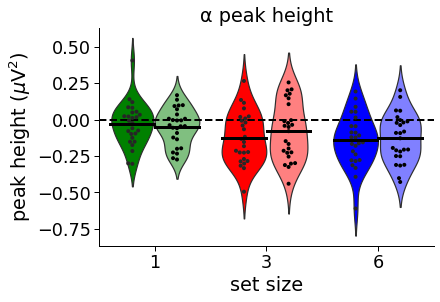

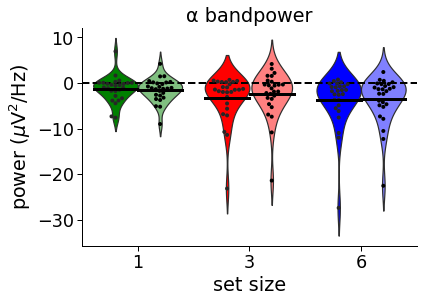

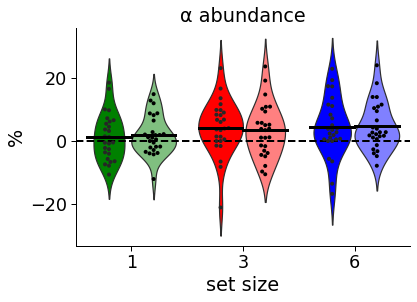

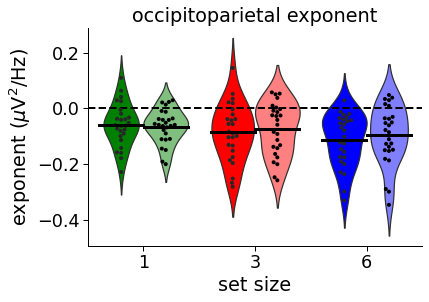

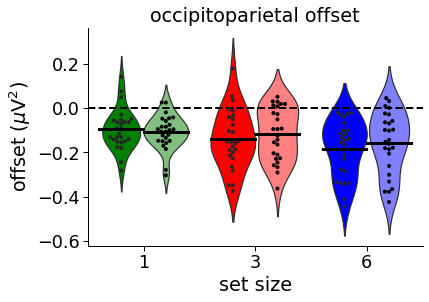

In [76]:
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='power', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='bandpower', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='peak_perc', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='exponent', frequency_band='alpha', save_fig=True)
dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='offset', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc_log_osc', frequency_band='alpha', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_alpha_avg_diff, parameter='auc_lin_osc', frequency_band='alpha', save_fig=True)

# Theta Analyses


# Group that has theta oscillations identified

In [77]:
# preparing the dataframe
all_cols = df_theta_avg.columns
df_theta_avg_diff = df_theta_avg.query('bas_ret_diff == "diff"')[all_cols]
df_theta_avg_ret = df_theta_avg.query('bas_ret_diff == "ret"')[all_cols]
df_theta_avg_bas = df_theta_avg.query('bas_ret_diff == "bas"')[all_cols]

### THETA - AMPLITUDE (APERIODIC ADJUSTED POWER)

In [78]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['power'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        10.0  0.026328  0.076569 -0.111523 -0.010818   
             3.0        10.0  0.081365  0.096510 -0.034276  0.003819   
             6.0        10.0  0.063621  0.100854 -0.058163 -0.005375   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0       0.004666  0.078621  0.149485  
             3.0       0.070052  0.132466  0.262456  
             6.0       0.018318  0.150457  0.213265

In [79]:
df_theta_avg_bas.groupby(['bas_ret_diff'])['power'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,30.0,0.355959,0.08388,0.191175,0.304408,0.361836,0.416243,0.499708


In [80]:
df_theta_avg_ret.groupby(['bas_ret_diff'])['power'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,30.0,0.413064,0.131977,0.20588,0.322372,0.372981,0.502842,0.677741


In [81]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='power', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.958092,0.763921,True
3.0,0.945989,0.621353,True
6.0,0.879446,0.128594,True


In [82]:
# Sphericity with Maughly
pg.sphericity(df_theta_avg_diff, dv='power', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.9932833503730008, chi2=29.865667007460015, dof=2, pval=3.271544335343409e-07)

In [83]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='power', within='set_size', subject='sub_id')
pg.friedman(df_theta_avg_diff, dv='power', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.07,2,1.4,0.496585


In [84]:
# Posthoc <-- RM-ANOVA / FRIEDMAN WAS NOT SIGNIFICANT

### Theta - Amplitude different from 0 (different from baseline)

In [85]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['power'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['power'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.958292  0.766236    True
         W      pval  normal
0  0.91087  0.287021    True
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  2.720515    9   two-sided  0.023588  [0.01, 0.1]  0.539641  3.142   

          power  
T-test  0.33248  


### THETA - LOG AUC (APERIODIC ADJUSTED POWER)

In [86]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['auc_log_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        10.0  0.012622  0.100728 -0.147716 -0.070128   
             3.0        10.0  0.079370  0.130299 -0.133538  0.008528   
             6.0        10.0  0.045421  0.106888 -0.073968 -0.035629   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0       0.030430  0.104942  0.124920  
             3.0       0.075134  0.149694  0.318964  
             6.0       0.010153  0.123487  0.205583

In [87]:
df_theta_avg_bas.groupby(['bas_ret_diff'])['auc_log_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,30.0,0.731469,0.107825,0.472119,0.653481,0.753519,0.808452,0.904586


In [88]:
df_theta_avg_ret.groupby(['bas_ret_diff'])['auc_log_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,30.0,0.777273,0.135188,0.49188,0.682981,0.789243,0.869329,1.050822


In [89]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='auc_log_osc', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.910201,0.282377,True
3.0,0.988600,0.994804,True
6.0,0.874135,0.111666,True


In [90]:
# Sphericity with Maughly
pg.sphericity(df_theta_avg_diff, dv='auc_log_osc', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.7946194135969813, chi2=25.892388271939627, dof=2, pval=2.3852797713131e-06)

In [91]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='power', within='set_size', subject='sub_id')
pg.friedman(df_theta_avg_diff, dv='auc_log_osc', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.13,2,2.6,0.272532


In [92]:
# Posthoc <-- RM-ANOVA / FRIEDMAN WAS NOT SIGNIFICANT

### Theta - LOG AUC different from 0 (different from baseline)

In [93]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['auc_log_osc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['auc_log_osc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.929292  0.440961    True
          W      pval  normal
0  0.955841  0.737613    True
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.688006    9   two-sided  0.125681  [-0.02, 0.11]  0.396884  0.897   

           power  
T-test  0.202697  


### THETA - LINEAR AUC (APERIODIC ADJUSTED POWER)

In [94]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['auc_lin_osc'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        10.0 -0.747413  2.595090 -4.680982 -2.824149   
             3.0        10.0  2.333594  4.976793 -4.174756 -0.542674   
             6.0        10.0  0.548079  2.987060 -3.491315 -0.903565   

                            50%       75%        max  
bas_ret_diff set_size                                 
diff         1.0      -0.424896  1.183261   2.580060  
             3.0       0.759806  4.444077  13.626553  
             6.0      -0.000252  1.129157   7.727171

In [95]:
df_theta_avg_bas.groupby(['bas_ret_diff'])['auc_lin_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,30.0,12.319417,5.806312,4.684333,9.734145,11.875263,14.72547,30.692509


In [96]:
df_theta_avg_ret.groupby(['bas_ret_diff'])['auc_lin_osc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,30.0,13.030836,7.254138,3.515062,8.551485,11.205829,15.662295,32.571025


In [97]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='auc_lin_osc', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.936978,0.519902,True
3.0,0.901215,0.225919,True
6.0,0.869285,0.098065,True


In [98]:
# Sphericity with Maughly
pg.sphericity(df_theta_avg_diff, dv='auc_lin_osc', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.7855892458019544, chi2=25.71178491603909, dof=2, pval=2.6106992568262227e-06)

In [99]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='power', within='set_size', subject='sub_id')
pg.friedman(df_theta_avg_diff, dv='auc_lin_osc', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.12,2,2.4,0.301194


In [100]:
# Posthoc <-- RM-ANOVA / FRIEDMAN WAS NOT SIGNIFICANT

### Theta - LINEAR AUC different from 0 (different from baseline)

In [101]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['auc_lin_osc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['auc_lin_osc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
# pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.862613  0.081913    True
         W      pval  normal
0  0.91766  0.337851    True
               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  0.873077    9   two-sided  0.405313  [-1.13, 2.55]  0.10884  0.423   

           power  
T-test  0.061015  


### THETA - CENTER FREQUENCY

In [102]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['cf'].describe()

In [103]:
# Normality with Shapiro Wilk
# pg.normality(data=df_theta_avg_diff, dv='cf', group='set_size', method='shapiro')

In [104]:
# Sphericity with Maughly
# pg.sphericity(df_theta_avg_diff, dv='cf', within='set_size', subject='sub_id', method='maughly')

In [105]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='cf', within='set_size', subject='sub_id')
# pg.friedman(df_theta_avg_diff, dv='cf', within='set_size', subject='sub_id')

### THETA - EXPONENT (we're not using exponent and offset for this sub-group)

In [106]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['exponent'].describe()

In [107]:
# Normality with Shapiro Wilk
# pg.normality(data=df_theta_avg_diff, dv='exponent', group='set_size', method='shapiro')

In [108]:
# Sphericity with Maughly
# pg.sphericity(df_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id', method='maughly')

In [109]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id')
# pg.friedman(df_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id')


### Theta - EXPONENT different from 0 (different from baseline)

In [110]:
# print(pg.ttest(df_theta_avg_diff.query('set_size == 1')['exponent'].values, 0))
# print(pg.ttest(df_theta_avg_diff.query('set_size == 3')['exponent'].values, 0))
# print(pg.ttest(df_theta_avg_diff.query('set_size == 6')['exponent'].values, 0))

### THETA - OFFSET (we're not using exponent and offset for this sub-group)

In [111]:
# Descriptive statistics 
# df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['offset'].describe()

In [112]:
# Normality with Shapiro Wilk
# pg.normality(data=df_theta_avg_diff, dv='offset', group='set_size', method='shapiro')

In [113]:
# Sphericity with Maughly
# pg.sphericity(df_theta_avg_diff, dv='offset', within='set_size', subject='sub_id', method='maughly')

In [114]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='offset', within='set_size', subject='sub_id')
# pg.friedman(df_theta_avg_diff, dv='offset', within='set_size', subject='sub_id')


### THETA - CENTER FREQUENCY PERCENTAGE OVER TRIALS

In [115]:
# Descriptive statistics 
df_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['peak_perc'].describe()

count      mean       std        min        25%  \
bas_ret_diff set_size                                                    
diff         1.0        10.0 -2.112341  5.416563 -11.200000  -5.643832   
             3.0        10.0 -5.364727  7.375314 -16.525424 -10.335429   
             6.0        10.0 -4.084508  7.067098 -18.565401  -5.803546   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -1.440329  0.897574  7.878788  
             3.0      -5.614965  0.431034  4.379562  
             6.0      -3.352332  0.548332  6.097561

In [116]:
df_theta_avg_bas.groupby(['bas_ret_diff'])['peak_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,30.0,64.520907,9.258955,45.255474,58.384565,64.955882,68.169122,83.060109


In [117]:
df_theta_avg_ret.groupby(['bas_ret_diff'])['peak_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,30.0,60.667048,9.990188,41.732283,51.169065,61.621146,66.674387,80.555556


In [118]:
# Normality with Shapiro Wilk
pg.normality(data=df_theta_avg_diff, dv='peak_perc', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.973682,0.922731,True
3.0,0.941689,0.571954,True
6.0,0.941715,0.572253,True


In [119]:
# Sphericity with Maughly
pg.sphericity(df_theta_avg_diff, dv='peak_perc', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.7788938498085667, chi2=25.577876996171334, dof=2, pval=2.7914803872978824e-06)

In [120]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_theta_avg_diff, dv='peak_perc', within='set_size', subject='sub_id')
pg.friedman(df_theta_avg_diff, dv='peak_perc', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.01,2,0.2,0.904837


### Theta - Percent peak different from 0 (different from baseline)

In [121]:
theta_avg_bas = df_theta_avg_bas.groupby(['sub_id'])['peak_perc'].mean().values
theta_avg_ret = df_theta_avg_ret.groupby(['sub_id'])['peak_perc'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.961568  0.803594    True
          W      pval  normal
0  0.945456  0.615149    True


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,7.0,two-sided,0.037109,-0.745455,0.36


### THETA - FIGURES

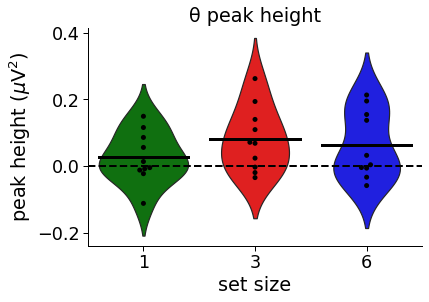

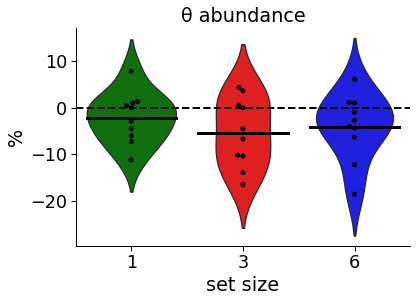

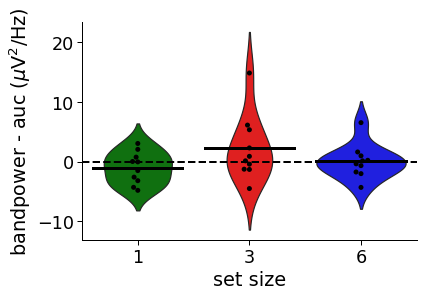

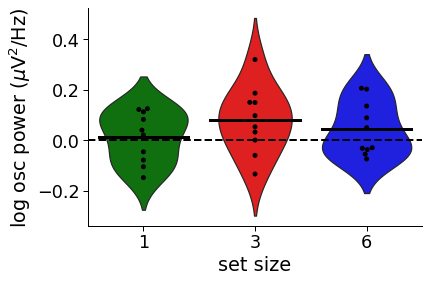

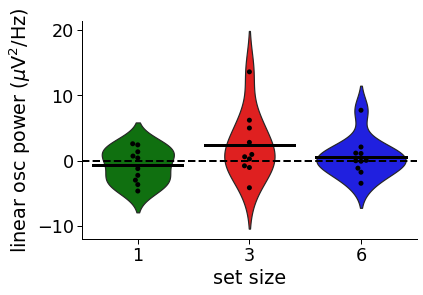

In [122]:
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='power', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='cf', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='peak_perc', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='exponent', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='offset', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc_log_osc', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_theta_avg_diff, parameter='auc_lin_osc', frequency_band='theta', save_fig=True)

# Group that DOES NOT HAVE theta oscillations identified

In [123]:
# preparing the dataframe
all_cols = df_no_theta_avg.columns
df_no_theta_avg_diff = df_no_theta_avg.query('bas_ret_diff == "diff"')[all_cols]
df_no_theta_avg_ret = df_no_theta_avg.query('bas_ret_diff == "ret"')[all_cols]
df_no_theta_avg_bas = df_no_theta_avg.query('bas_ret_diff == "bas"')[all_cols]

### NO THETA - EXPONENT


In [124]:
# Descriptive statistics 
df_no_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        16.0 -0.017837  0.062048 -0.146789 -0.059371   
             3.0        16.0 -0.042632  0.073408 -0.177838 -0.089369   
             6.0        16.0 -0.042696  0.087992 -0.251590 -0.082375   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -0.017020  0.021760  0.086279  
             3.0      -0.050404 -0.004677  0.074775  
             6.0      -0.034153  0.000466  0.128663

In [125]:
# Normality with Shapiro Wilk
pg.normality(data=df_no_theta_avg_diff, dv='exponent', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.983060,0.983164,True
3.0,0.964781,0.748628,True
6.0,0.971994,0.869779,True


In [126]:
# Sphericity with Maughly
pg.sphericity(df_no_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.793039905404581, chi2=41.37727697294659, dof=2, pval=1.0352338575032252e-09)

In [127]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_no_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id')
pg.friedman(df_no_theta_avg_diff, dv='exponent', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.082031,2,2.625,0.269146


### NO  Theta - EXPONENT different from 0 (different from baseline)

In [128]:
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 1')['exponent'].values, 0))
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 3')['exponent'].values, 0))
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 6')['exponent'].values, 0))

               T  dof alternative     p-val          CI95%   cohen-d  BF10  \
T-test -1.149899   15   two-sided  0.268189  [-0.05, 0.02]  0.287475  0.45   

           power  
T-test  0.189908  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -2.322995   15   two-sided  0.034648  [-0.08, -0.0]  0.580749  2.003   

          power  
T-test  0.58434  
               T  dof alternative   p-val         CI95%   cohen-d   BF10  \
T-test -1.940911   15   two-sided  0.0713  [-0.09, 0.0]  0.485228  1.145   

           power  
T-test  0.443035  


### NO THETA - OFFSET 

In [129]:
# Descriptive statistics 
df_no_theta_avg_diff.groupby(['bas_ret_diff', 'set_size'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        16.0 -0.048271  0.088684 -0.271319 -0.103001   
             3.0        16.0 -0.089656  0.097916 -0.347259 -0.124688   
             6.0        16.0 -0.093567  0.137477 -0.474729 -0.139057   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -0.041255 -0.000654  0.080435  
             3.0      -0.078995 -0.044905  0.057371  
             6.0      -0.077721 -0.014193  0.122960

In [130]:
# Normality with Shapiro Wilk
pg.normality(data=df_no_theta_avg_diff, dv='offset', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.941088,0.362561,True
3.0,0.929263,0.237315,True
6.0,0.892399,0.060798,True


In [131]:
# Sphericity with Maughly
pg.sphericity(df_no_theta_avg_diff, dv='offset', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.8320314819583767, chi2=42.625007422668055, dof=2, pval=5.54749912783221e-10)

In [132]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_no_theta_avg_diff, dv='offset', within='set_size', subject='sub_id')
pg.friedman(df_no_theta_avg_diff, dv='offset', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.082031,2,2.625,0.269146


### NO Theta - OFFSET different from 0 (different from baseline)

In [133]:
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 1')['offset'].values, 0))
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 3')['offset'].values, 0))
print(pg.ttest(df_no_theta_avg_diff.query('set_size == 6')['offset'].values, 0))

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -2.177203   15   two-sided  0.045844  [-0.1, -0.0]  0.544301  1.608   

          power  
T-test  0.53072  
               T  dof alternative    p-val           CI95%   cohen-d   BF10  \
T-test -3.662575   15   two-sided  0.00231  [-0.14, -0.04]  0.915644  18.69   

           power  
T-test  0.927811  
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.722388   15   two-sided  0.015736  [-0.17, -0.02]  0.680597  3.772   

           power  
T-test  0.720779  


### NO THETA - FIGURES

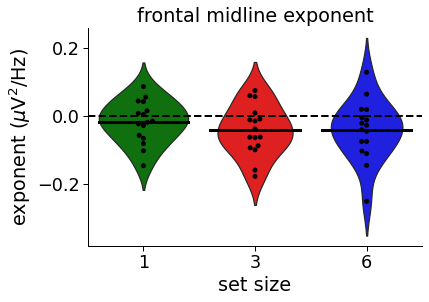

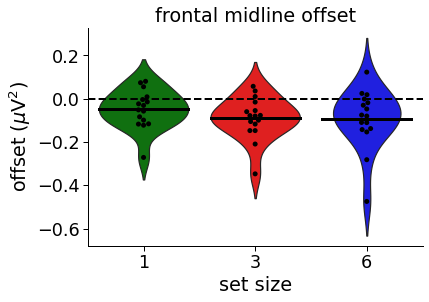

In [134]:
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='power', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='cf', frequency_band='theta', save_fig=False)
# dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='peak_perc', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='exponent', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_no_theta_avg_diff, parameter='offset', frequency_band='theta', save_fig=False)

# Combined with and without theta oscillations for aperiodic analysis only

In [135]:
# preparing the dataframe & combining with and without oscillations
df_all_theta_diff = pd.concat([df_theta_avg_diff, df_no_theta_avg_diff])
df_all_theta_bas = pd.concat([df_theta_avg_bas, df_no_theta_avg_bas])
df_all_theta_ret = pd.concat([df_theta_avg_ret, df_no_theta_avg_ret])

### ALL THETA - EXPONENT

In [136]:
# Descriptive statistics 
df_all_theta_bas.groupby(['bas_ret_diff'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,78.0,1.172135,0.359286,-0.01725,1.018433,1.225087,1.425179,1.647155


In [137]:
# Descriptive statistics 
df_all_theta_ret.groupby(['bas_ret_diff'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,78.0,1.140047,0.363835,-0.069941,0.990995,1.221313,1.357078,1.686838


In [138]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'set_size'])['exponent'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        26.0 -0.024511  0.060522 -0.146789 -0.064183   
             3.0        26.0 -0.034166  0.067239 -0.177838 -0.081858   
             6.0        26.0 -0.037588  0.081407 -0.251590 -0.083742   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -0.021198  0.023119  0.086279  
             3.0      -0.026739  0.016119  0.074775  
             6.0      -0.032894  0.019358  0.128663

In [139]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff, dv='exponent', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.974591,0.743650,True
3.0,0.970767,0.643312,True
6.0,0.978498,0.840561,True


In [140]:
# Sphericity with Maughly
pg.sphericity(df_all_theta_diff, dv='exponent', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.989868194293332, chi2=77.47314610325327, dof=2, pval=1.5028653650379505e-17)

In [141]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_all_theta_diff, dv='exponent', within='set_size', subject='sub_id')
pg.friedman(df_all_theta_diff, dv='exponent', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.04142,2,2.153846,0.340642


### ALL Theta - EXPONENT different from 0 (different from baseline)

In [142]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['exponent'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['exponent'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.900979  0.016465   False
          W      pval  normal
0  0.915428  0.035173   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,66.0,two-sided,0.005634,-0.623932,0.477811


### ALL THETA - OFFSET 

In [143]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'set_size'])['offset'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        26.0 -0.052896  0.084291 -0.271319 -0.111671   
             3.0        26.0 -0.076659  0.087414 -0.347259 -0.114235   
             6.0        26.0 -0.087252  0.120326 -0.474729 -0.141390   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -0.042088 -0.003282  0.080435  
             3.0      -0.077486 -0.016081  0.057371  
             6.0      -0.077721 -0.005610  0.122960

In [144]:
df_all_theta_bas.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,78.0,1.024156,0.36164,0.255986,0.755841,1.061642,1.325771,1.586655


In [145]:
df_all_theta_ret.groupby(['bas_ret_diff'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,78.0,0.951887,0.361841,0.212087,0.66937,0.9944,1.270208,1.478934


In [146]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff, dv='offset', group='set_size', method='shapiro')

,W,pval,normal
1.0,0.967366,0.556373,True
3.0,0.932156,0.087225,True
6.0,0.917270,0.038819,False


In [147]:
# Sphericity with Maughly
pg.sphericity(df_all_theta_diff, dv='offset', within='set_size', subject='sub_id', method='maughly')

SpherResults(spher=False, W=1.989359797868735, chi2=77.44670948917422, dof=2, pval=1.5228625743336997e-17)

In [148]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_all_theta_diff, dv='offset', within='set_size', subject='sub_id')
pg.friedman(df_all_theta_diff, dv='offset', within='set_size', subject='sub_id')


,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.045858,2,2.384615,0.30352


### ALL Theta - OFFSET different from 0 (different from baseline)

In [149]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['offset'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['offset'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
pg.wilcoxon(theta_avg_ret, theta_avg_bas)

          W      pval  normal
0  0.945904  0.185668    True
          W      pval  normal
0  0.920072  0.045137   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,20.0,two-sided,0.000083,-0.88604,0.439349


### ALL THETA - BANDPOWER

In [150]:
# Descriptive statistics 
df_all_theta_diff.groupby(['bas_ret_diff', 'set_size'])['bandpower'].describe()

count      mean       std       min       25%  \
bas_ret_diff set_size                                                  
diff         1.0        26.0 -0.541437  0.967083 -2.524596 -1.056725   
             3.0        26.0 -0.165262  2.247923 -3.783506 -0.897131   
             6.0        26.0 -0.451712  1.277784 -3.822817 -0.848650   

                            50%       75%       max  
bas_ret_diff set_size                                
diff         1.0      -0.394737 -0.002587  1.656976  
             3.0      -0.470842  0.055543  7.881771  
             6.0      -0.347136  0.037545  2.890470

In [151]:
df_all_theta_bas.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
bas,78.0,6.849369,4.085599,1.407109,3.456904,6.327711,9.687629,20.086886


In [152]:
df_all_theta_ret.groupby(['bas_ret_diff'])['bandpower'].describe()

,count,mean,std,min,25%,50%,75%,max
bas_ret_diff,,,,,,,,
ret,78.0,6.463232,4.52591,1.121078,2.979597,5.043212,8.721804,20.734606


In [153]:
# Normality with Shapiro Wilk
print(pg.normality(data=df_all_theta_diff, dv='bandpower', group='set_size', method='shapiro'))

            W      pval  normal
1.0  0.958375  0.360575    True
3.0  0.837289  0.000814   False
6.0  0.909810  0.026100   False


In [154]:
# RM-ANOVA or unparametric alternative (friedman test)
# pg.rm_anova(df_all_theta_diff, dv='offset', within='set_size', subject='sub_id')
pg.friedman(df_all_theta_diff, dv='bandpower', within='set_size', subject='sub_id')

,Source,W,ddof1,Q,p-unc
Friedman,set_size,0.028107,2,1.461538,0.481538


#### Theta - Bandpower different from 0 (different from baseline)

In [155]:
theta_avg_bas = df_all_theta_bas.groupby(['sub_id'])['bandpower'].mean().values
theta_avg_ret = df_all_theta_ret.groupby(['sub_id'])['bandpower'].mean().values

# Normality
print(pg.normality(theta_avg_bas))
print(pg.normality(theta_avg_ret))

# Paired t-test or wilcoxon if data is not-parametric
# print(pg.ttest(theta_avg_ret, theta_avg_bas, paired=True))
pg.wilcoxon(theta_avg_ret, theta_avg_bas)

         W     pval  normal
0  0.93276  0.09017    True
          W      pval  normal
0  0.894518  0.011834   False


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,89.0,two-sided,0.028946,-0.492877,0.45858


### ALL THETA - FIGURES

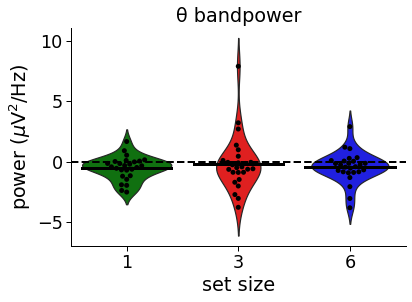

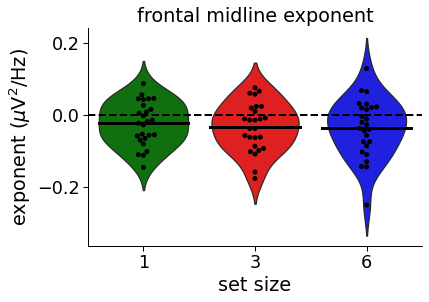

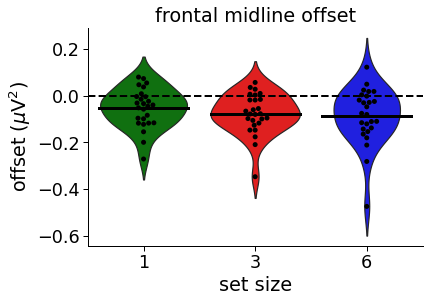

In [156]:
# dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='power', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='bandpower', frequency_band='theta', save_fig=True)
# dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='peak_perc', frequency_band='theta', save_fig=False)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='exponent', frequency_band='theta', save_fig=True)
dp_plot.plot_violin_swarms(data=df_all_theta_diff, parameter='offset', frequency_band='theta', save_fig=True)

# THETA vs NO THETA

In [157]:
# Prepare dataframe difference --> basically ignore performance for this
df_all_theta_diff_avg = df_all_theta_diff.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_diff_avg.loc[df_all_theta_diff_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'


# Prepare dataframe baseline --> basically ignore performance for this
df_all_theta_bas_avg = df_all_theta_bas.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_bas_avg.loc[df_all_theta_bas_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'


# Prepare dataframe retention --> basically ignore performance for this
df_all_theta_ret_avg = df_all_theta_ret.groupby('sub_id').mean()

# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 0.0, 'osc_presence'] = 'no'
df_all_theta_ret_avg.loc[df_all_theta_ret_avg.osc_presence == 1.0, 'osc_presence'] = 'yes'

#### Exponent statistics -- DIFFERENCE


In [158]:
# Descriptive statistics 
df_all_theta_diff_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,-0.034388,0.060593,-0.192072,-0.050148,-0.029629,-0.011462,0.090635
yes,10.0,-0.028409,0.048598,-0.098739,-0.065054,-0.023851,0.015165,0.032468


In [159]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.923091,0.383461,True
no,0.907761,0.107094,True


In [160]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.002295,0.962189,True


In [161]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.277115,22.334686,two-sided,0.784241,"[-0.04, 0.05]",0.106035,0.38,0.057346


#### Exponent statistics -- RETENTION

In [162]:
# Descriptive statistics 
df_all_theta_ret_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,1.049897,0.383835,0.001568,0.921620,1.072009,1.214914,1.655209
yes,10.0,1.284286,0.301339,0.501150,1.264817,1.315183,1.437028,1.635813


In [163]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_ret_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.745976,0.003188,False
no,0.914827,0.139220,True


In [164]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_ret_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.597591,0.447046,True


In [165]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_ret_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_ret_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
pg.mwu(df_all_theta_ret_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_ret_avg.query('osc_presence == "no"')['exponent'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,121.0,two-sided,0.032799,-0.5125,0.75625


#### Exponent statistics -- BASELINE

In [166]:
# Descriptive statistics 
df_all_theta_bas_avg.groupby(['osc_presence'])['exponent'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,1.084285,0.382886,0.013623,0.965049,1.084171,1.239785,1.624382
yes,10.0,1.312695,0.291906,0.570989,1.251045,1.374411,1.457677,1.611323


In [167]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_bas_avg, dv='exponent', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.793264,0.012007,False
no,0.882288,0.042130,False


In [168]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_bas_avg, dv='exponent', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.487414,0.491793,True


In [169]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_bas_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_bas_avg.query('osc_presence == "no"')['exponent'].values)

# unparametric alternative
pg.mwu(df_all_theta_bas_avg.query('osc_presence == "yes"')['exponent'].values, 
               df_all_theta_bas_avg.query('osc_presence == "no"')['exponent'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,118.0,two-sided,0.048107,-0.475,0.7375


### Offset statistics -- RETENTION

In [170]:
# Descriptive statistics 
df_all_theta_ret_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,0.83518,0.375194,0.286599,0.525577,0.899725,1.031646,1.437049
yes,10.0,1.13862,0.265071,0.579406,1.110271,1.235482,1.304730,1.395427


In [171]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_ret_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.828321,0.031938,False
no,0.937887,0.323939,True


In [172]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_ret_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,1.854236,0.185938,True


In [173]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_ret_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_ret_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
pg.mwu(df_all_theta_ret_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_ret_avg.query('osc_presence == "no"')['offset'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,119.0,two-sided,0.042445,-0.4875,0.74375


### Offset statistics -- DIFFERENCE


In [174]:
# Descriptive statistics 
df_all_theta_diff_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,-0.077165,0.092372,-0.364435,-0.101824,-0.064581,-0.040085,0.071199
yes,10.0,-0.064435,0.056000,-0.148521,-0.099759,-0.079731,-0.021960,0.015223


In [175]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_diff_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.933898,0.487307,True
no,0.813323,0.004116,False


In [176]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.110216,0.742781,True


In [177]:
# t-test for unparametric alternative
# pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['offset'].values)

,U-val,alternative,p-val,RBC,CLES
MWU,82.0,two-sided,0.936987,-0.025,0.5125


### Offset statistics -- BASELINE

In [178]:
# Descriptive statistics 
df_all_theta_bas_avg.groupby(['osc_presence'])['offset'].describe()

,count,mean,std,min,25%,50%,75%,max
osc_presence,,,,,,,,
no,16.0,0.912344,0.382369,0.321173,0.632198,0.931329,1.153911,1.545688
yes,10.0,1.203055,0.258151,0.677043,1.178364,1.243799,1.361431,1.512649


In [179]:
# Normality with Shapiro Wilk
pg.normality(data=df_all_theta_bas_avg, dv='offset', group='osc_presence', method='shapiro')

,W,pval,normal
yes,0.893072,0.183589,True
no,0.952702,0.533662,True


In [180]:
# Test for equal variance between groups
pg.homoscedasticity(data=df_all_theta_bas_avg, dv='offset', group='osc_presence', method='levene')

,W,pval,equal_var
levene,2.346164,0.138668,True


In [181]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_bas_avg.query('osc_presence == "yes"')['offset'].values, 
               df_all_theta_bas_avg.query('osc_presence == "no"')['offset'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['offset'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['offset'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.312617,23.778473,two-sided,0.029721,"[0.03, 0.55]",0.852199,2.345,0.527595


### Figures for theta vs no theta

In [182]:
# df_all_theta = pd.concat([df_theta_avg, df_no_theta_avg])


# Replace 1.0 and 0.0 with yes or no for the presence of an oscillation
# df_all_theta.loc[df_all_theta.osc_presence == 0.0, 'osc_presence'] = 'no'
# df_all_theta.loc[df_all_theta.osc_presence == 1.0, 'osc_presence'] = 'yes'

# df_all_theta.groupby(['set_size', 'bas_ret_diff'])['exponent'].describe()
# sns.violinplot(data=df_all_theta, x='osc_presence', y='exponent', hue='bas_ret_diff')

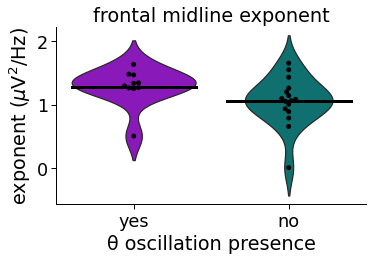

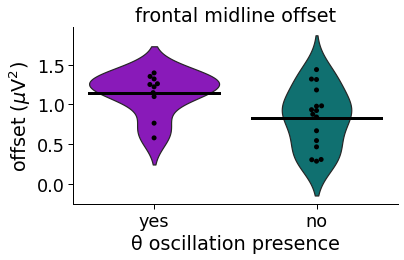

In [183]:
# difference values
dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='exponent', frequency_band='theta_presence', save_fig=True)
dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='offset', frequency_band='theta_presence', save_fig=True)

# retention values
# dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='exponent', frequency_band='theta_presence', zero=False, save_fig=True)
# dp_plot.plot_violin_swarms(data=df_all_theta_ret_avg, parameter='offset', frequency_band='theta_presence', zero=False, save_fig=True)

# Correlation of aperiodic with working memory capacity

In [184]:
# stats for correlation over osc present or not
print(pg.corr(x=df_all_theta_diff_avg['wm_capacity'], y=df_all_theta_diff_avg['exponent']))
print(pg.corr(x=df_all_theta_bas_avg['wm_capacity'], y=df_all_theta_bas_avg['exponent']))
print(pg.corr(x=df_all_theta_ret_avg['wm_capacity'], y=df_all_theta_ret_avg['exponent']))

          n         r         CI95%     p-val  BF10     power
pearson  26 -0.095753  [-0.47, 0.3]  0.641712  0.27  0.074882
          n         r          CI95%    p-val   BF10     power
pearson  26  0.155122  [-0.25, 0.51]  0.44925  0.319  0.118213
          n         r         CI95%     p-val   BF10     power
pearson  26  0.138865  [-0.26, 0.5]  0.498699  0.303  0.104071


In [185]:
print(pg.corr(x=df_all_theta_diff_avg['wm_capacity'], y=df_all_theta_diff_avg['offset']))
print(pg.corr(x=df_all_theta_bas_avg['wm_capacity'], y=df_all_theta_bas_avg['offset']))
print(pg.corr(x=df_all_theta_ret_avg['wm_capacity'], y=df_all_theta_ret_avg['offset']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.110613  [-0.48, 0.29]  0.590624  0.279  0.083618
          n         r          CI95%     p-val   BF10     power
pearson  26  0.165868  [-0.24, 0.52]  0.418053  0.332  0.128544
          n         r         CI95%     p-val   BF10     power
pearson  26  0.141824  [-0.26, 0.5]  0.489499  0.305  0.106515


Text(0.5, 1.0, 'exp 1')

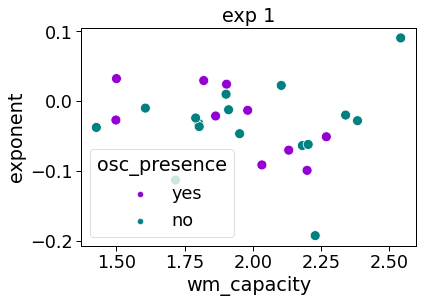

In [186]:
# Figure showing dots with different colors for osc_presence yes or no
# Delta aperiodic on y axis
# Average WM on x axis

theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}


sns.scatterplot(data=df_all_theta_diff_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)
plt.title('exp 1')

<AxesSubplot:xlabel='wm_capacity', ylabel='exponent'>

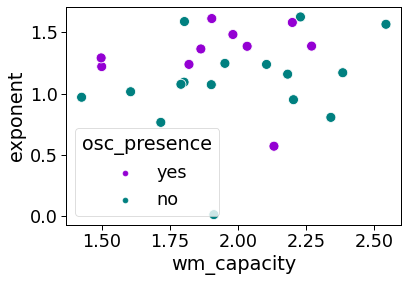

In [187]:
sns.scatterplot(data=df_all_theta_bas_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)

<AxesSubplot:xlabel='wm_capacity', ylabel='exponent'>

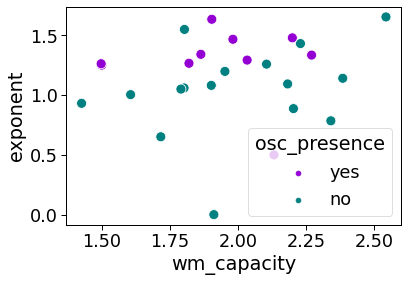

In [188]:
sns.scatterplot(data=df_all_theta_ret_avg, x='wm_capacity', y='exponent', hue='osc_presence', palette=theta_no_theta, s=100)

# THETA - Gender regression

In [189]:
# rename subject ID column so it matches with the other dataframe I make later on
dem.rename(columns={'Subject Num': 'sub_id'}, inplace=True)


In [190]:
# Create array with all sub id
all_subs = np.arange(1, 31+1, 1)
# Delete number 24 since it was ommited in the analysis earlier
all_subs = np.delete(all_subs, 24-1)

# Create array with subs who have no theta (residuals of all_subs & SUB_THETA)
sub_no_theta = []

for idx, sub in enumerate(all_subs):
    boolean = all_subs[idx] in SUB_THETA
    
    if not boolean:  # so basically, if FALSE --> then include that sub_id as no_theta
        sub_no_theta.append(sub)


In [191]:
# Now it's time to create a pandas dataframe with SUB_THETA and sub_no_theta
# We need the sub_id's as one column, and add a column whether they have theta or not
df_yes_theta = pd.DataFrame({'sub_id' : SUB_THETA, 'theta_presence' : 'yes'})
df_no_theta = pd.DataFrame({'sub_id' : sub_no_theta, 'theta_presence' : 'no'})

# Combine the 2 dataframes
df_theta = pd.concat([df_yes_theta, df_no_theta], axis=0)

In [192]:
# Now combine the dem dataframe with theta dataframe based on sub_id
df_theta_dem = pd.merge(df_theta, dem, on='sub_id', how='inner')

In [193]:
# Either logistic regression <-- only when outcome variable is continous. So this one is off the table
# Or Pearson Chi-Square or Likelihood Ratio according to the stats decision tree (flow chart)

expected, observed, stats = pg.chi2_independence(data=df_theta_dem, x='Sex', y='theta_presence')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/pingouin/contingency.py:150: UserWarning: Low count on expected frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))


In [194]:
expected

theta_presence,no,yes
Sex,,
F,7.2,4.8
M,10.8,7.2


In [195]:
observed

theta_presence,no,yes
Sex,,
F,8.5,3.5
M,9.5,8.5


In [196]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.978009,1.0,0.322691,0.180556,0.167364
1,cressie-read,0.666667,0.982991,1.0,0.321461,0.181015,0.167978
2,log-likelihood,0.000000,0.995692,1.0,0.318355,0.182180,0.169544
3,freeman-tukey,-0.500000,1.007745,1.0,0.315444,0.183280,0.171030
4,mod-log-likelihood,-1.000000,1.022110,1.0,0.312019,0.184582,0.172802
5,neyman,-2.000000,1.058399,1.0,0.303581,0.187830,0.177281


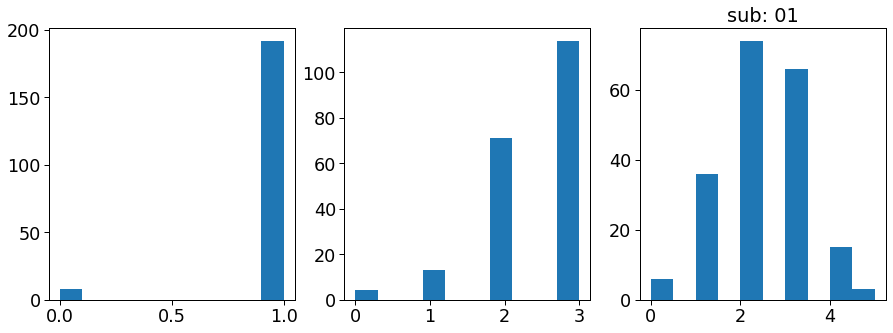

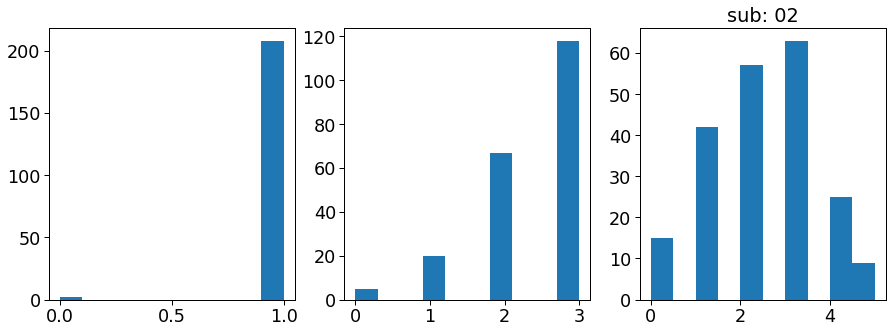

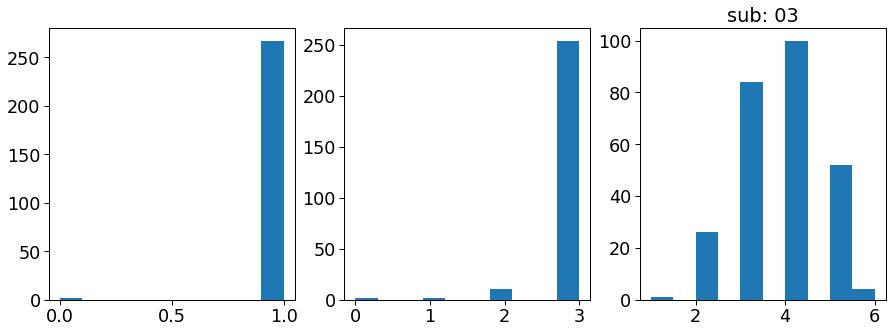

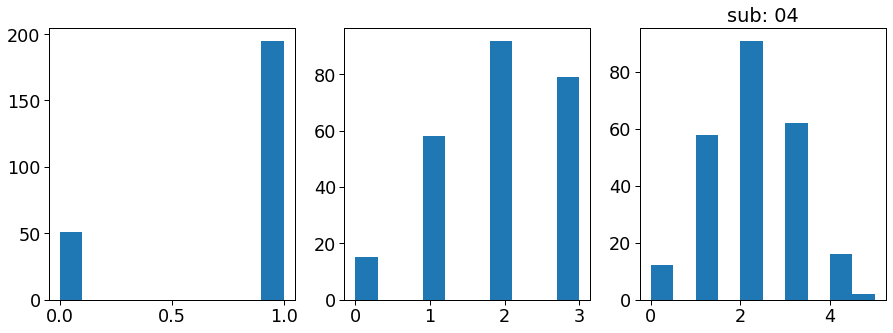

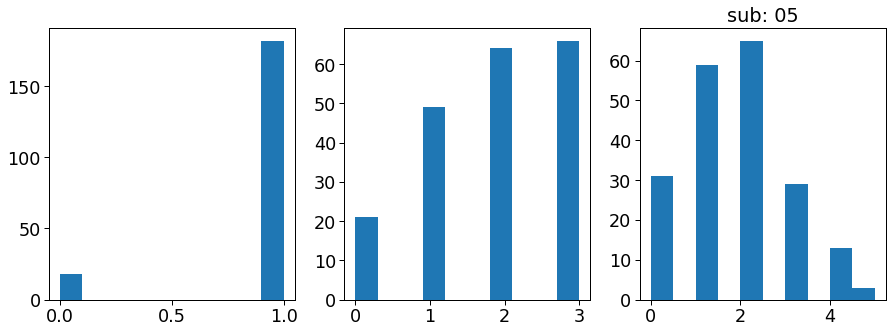

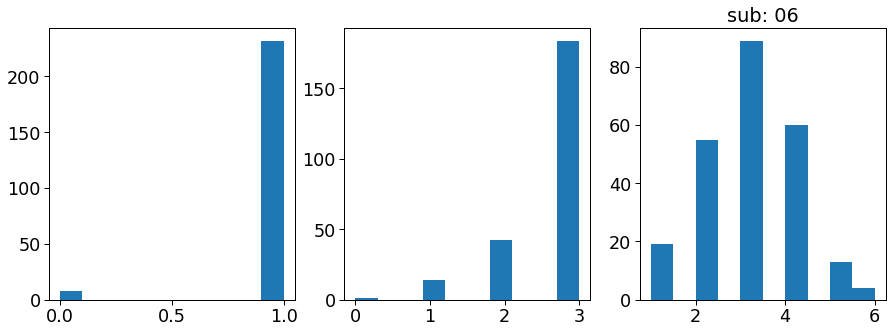

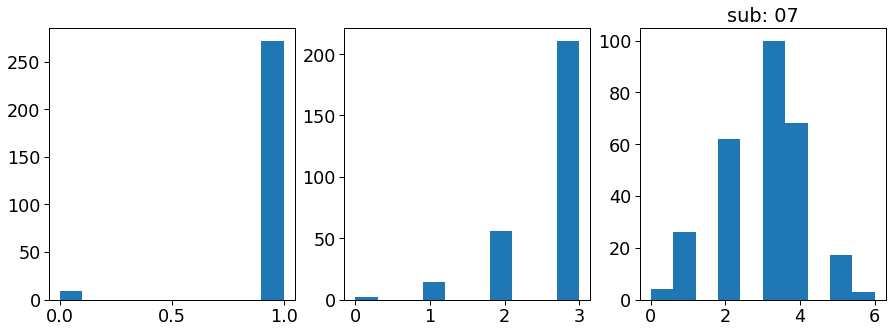

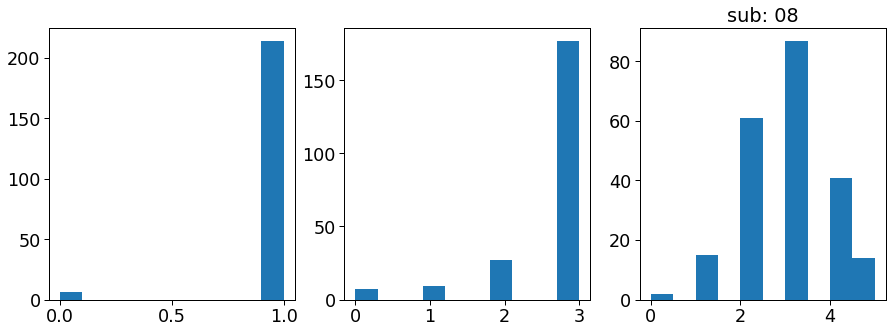

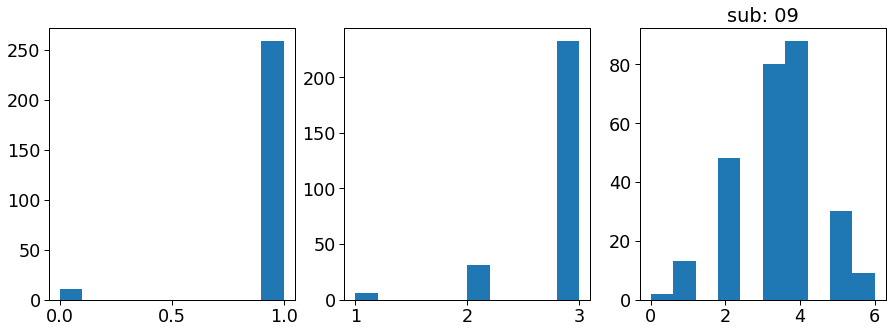

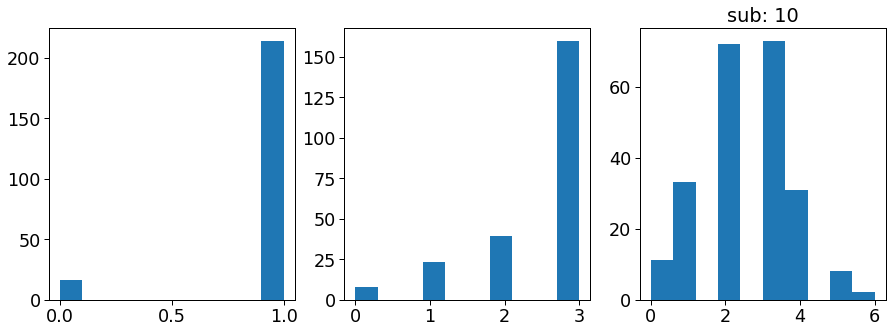

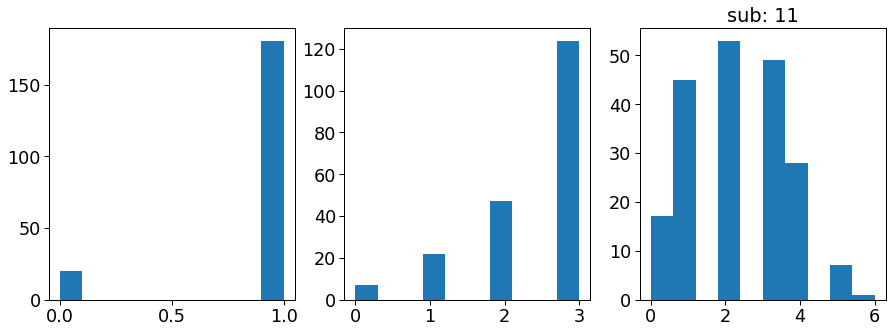

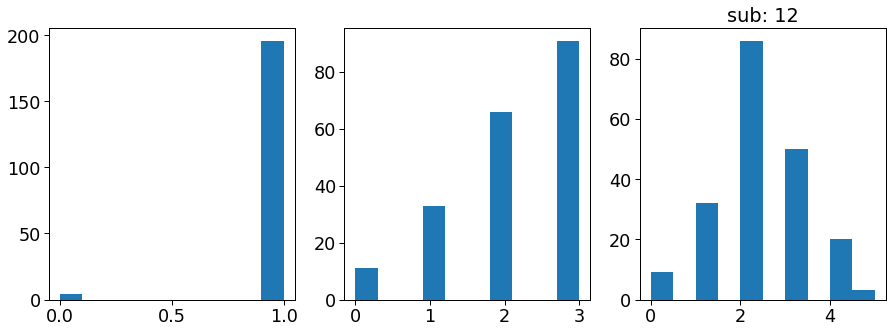

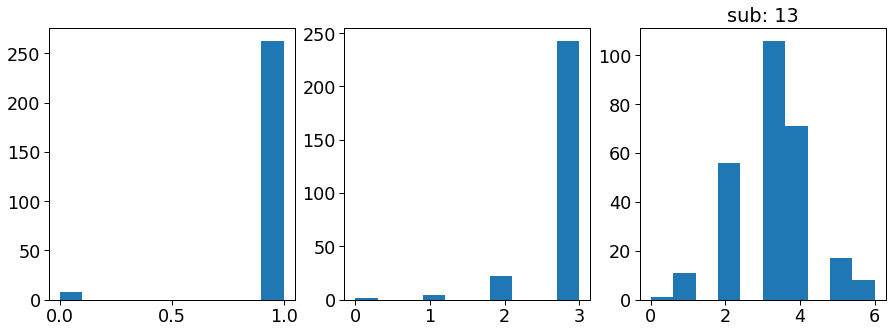

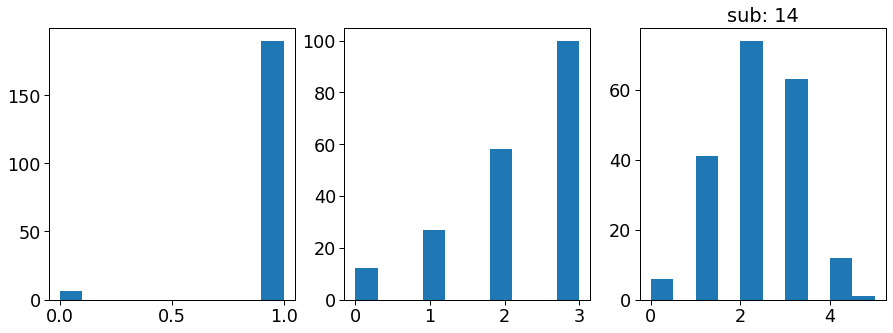

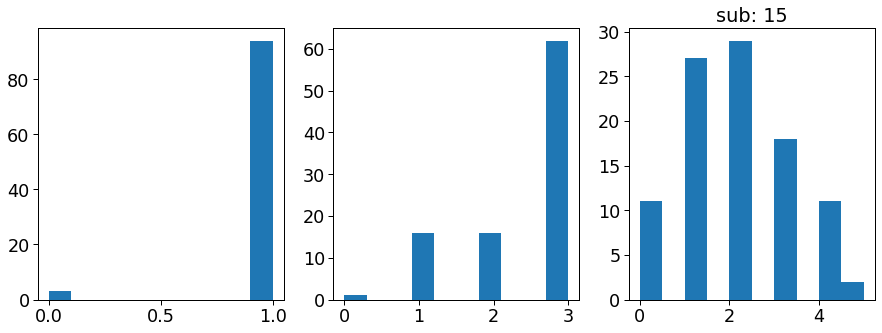

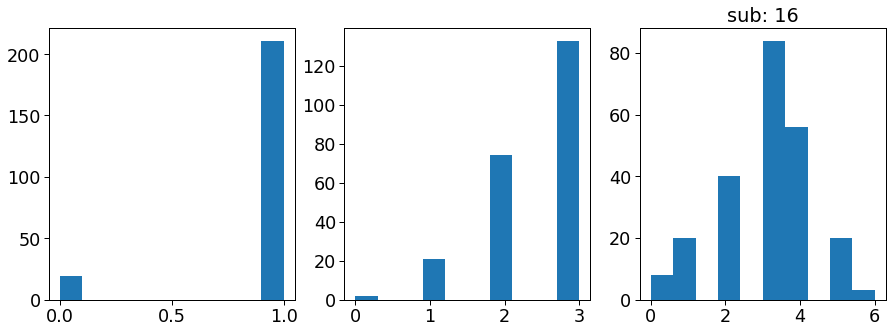

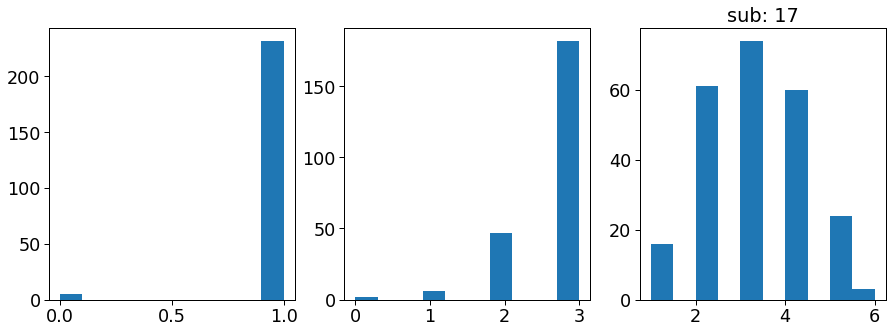

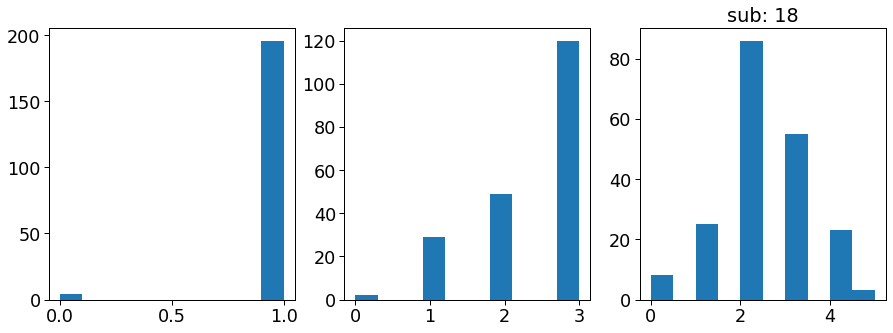

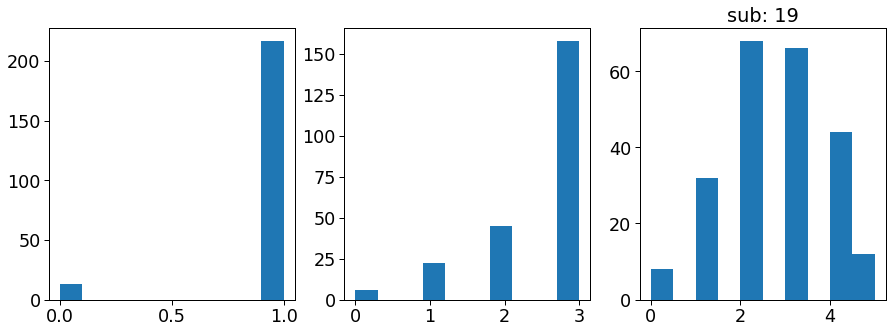

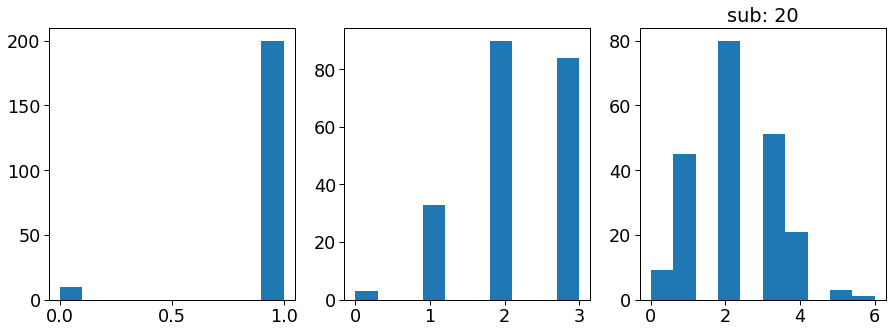

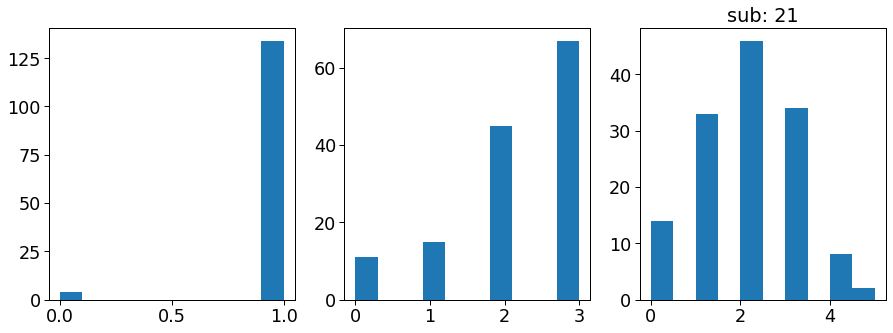

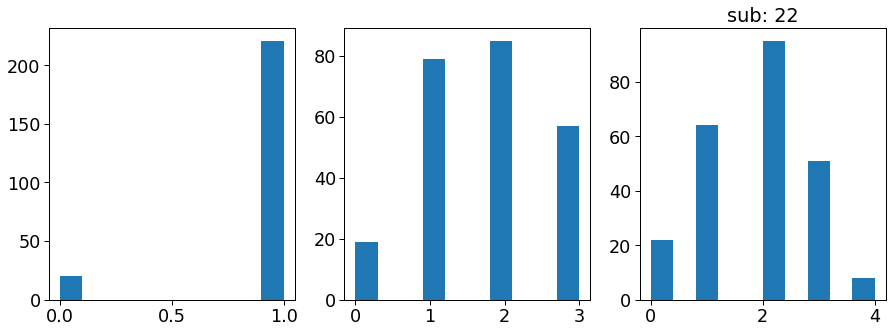

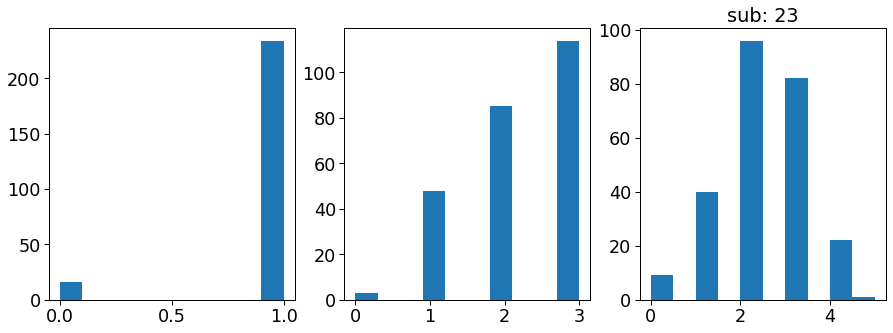

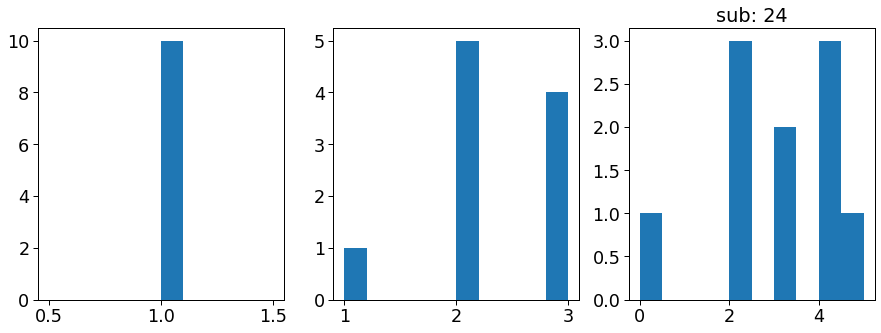

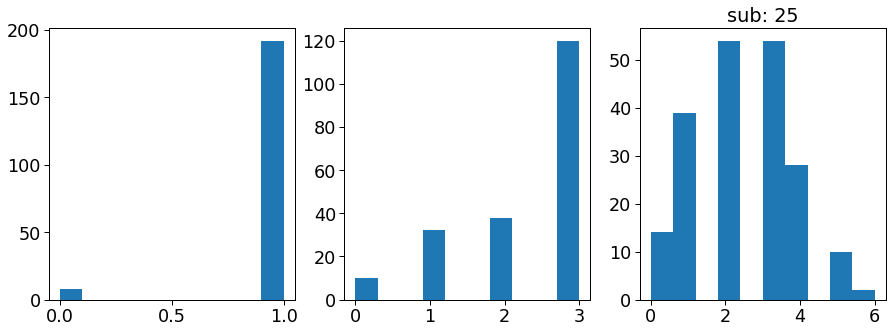

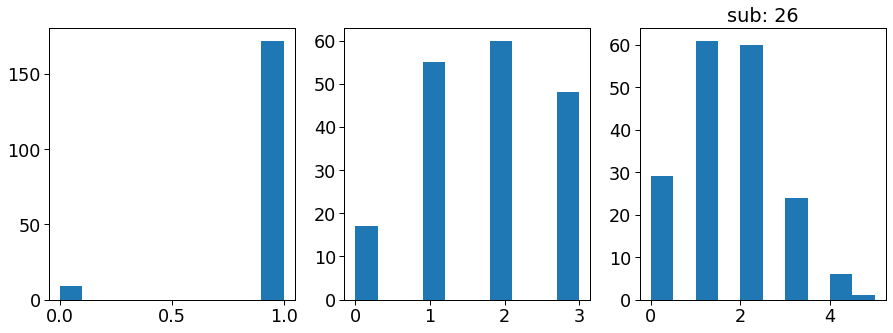

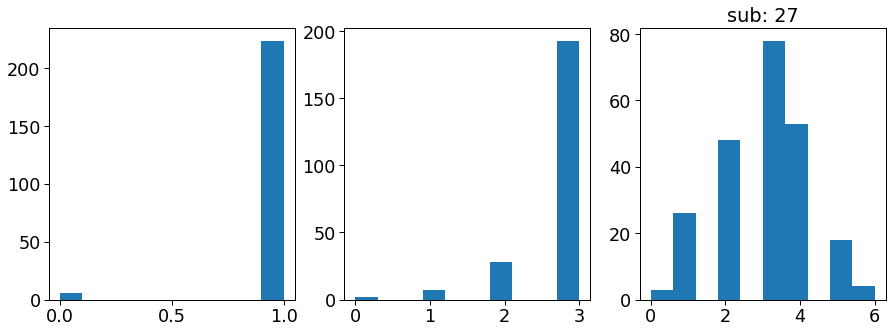

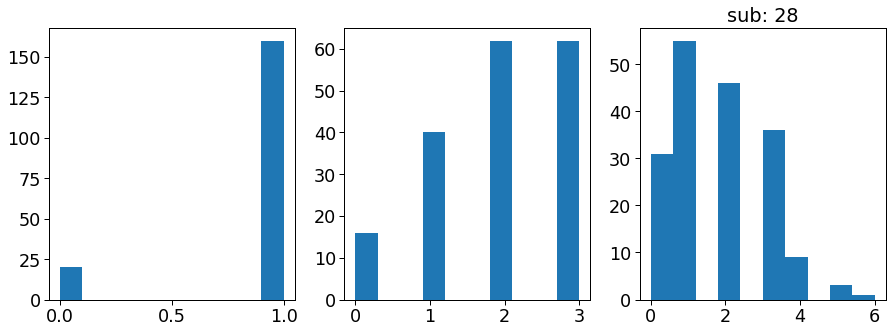

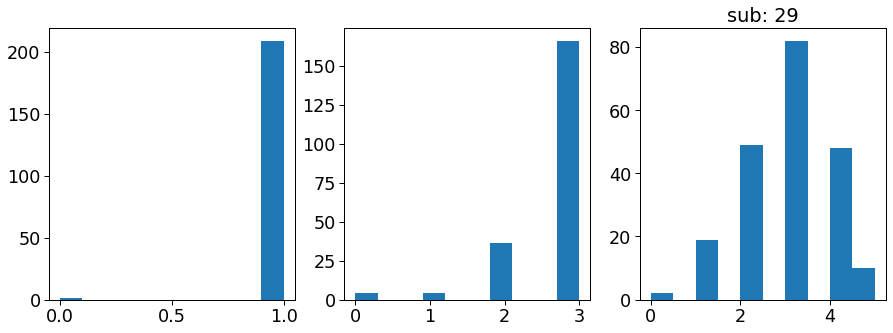

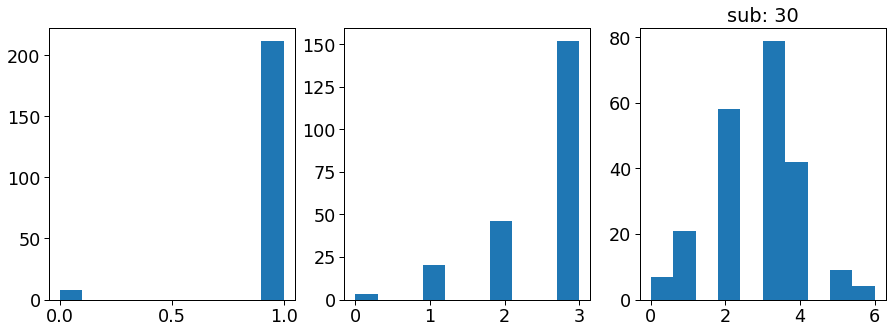

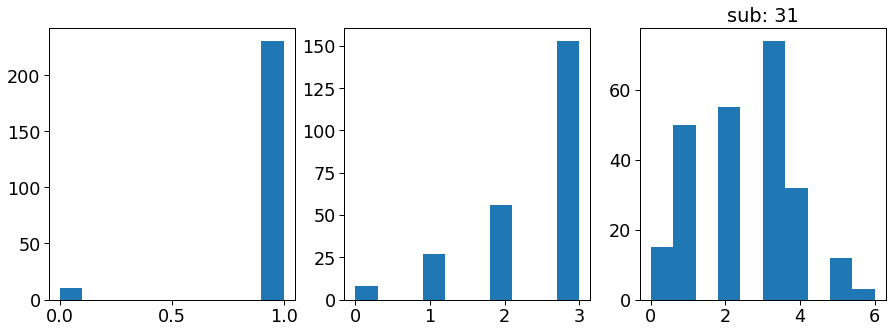

In [197]:
# Start looping over participants
from colourfulbirds import exp1_functionsforFOOOF as dp
from colourfulbirds import datahelper

beh_dat_path = "/Users/quirine/Documents/Projects/WM_fooof/Experiment_1/Behavior"

num_subjects = 31
ss1_avg = []
ss3_avg = []
ss6_avg = []
subs = []

for idx, sub in enumerate(range(1, num_subjects + 1)):
#     print(sub)
    
    subs.append(sub)
    
    beh_dat = None
    beh_dat_K = None

    if sub < 10:
        sub = '0' + str(sub)
        
    sub_beh_file = str(sub) + '_discreteWR_biLat.mat'
    sub_beh_file_K = str(sub) + '_ColorK.mat'

    # load data
    beh_dat = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file)
    beh_dat_K = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file_K)

    # select trial accuracy
    beh_dat_acc = beh_dat['data']['trialAcc'].flatten()
    beh_dat_ss = beh_dat['data']['setSize'].flatten()
    beh_dat_k_acc = beh_dat_K['stim']['accuracy']
    
    # get index for different setsize conditions; index into behavioral data
    ss1 = beh_dat_acc[np.where(beh_dat_ss == 1)]
    ss3 = beh_dat_acc[np.where(beh_dat_ss == 3)]
    ss6 = beh_dat_acc[np.where(beh_dat_ss == 6)]


    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,5])
    axs[0].hist(ss1)
    axs[1].hist(ss3)
    axs[2].hist(ss6)
    plt.title('sub: ' + str(sub))
    plt.show()



    ss1_avg.append(np.nanmean(ss1))
    ss3_avg.append(np.nanmean(ss3))
    ss6_avg.append(np.nanmean(ss6))
    
    


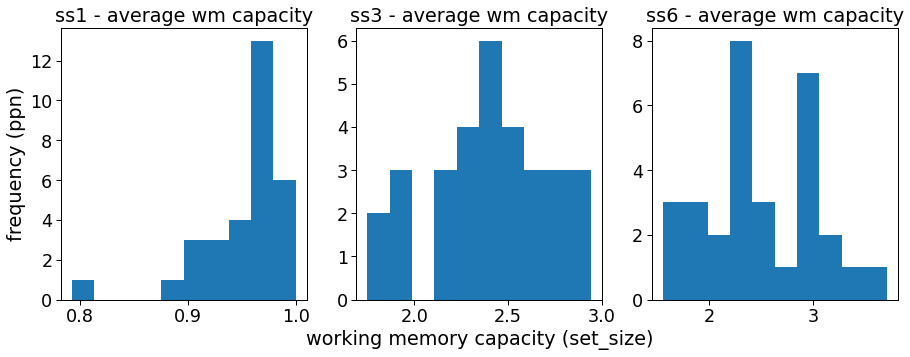

In [198]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,5])
axs[0].hist(ss1_avg)
axs[1].hist(ss3_avg)
axs[2].hist(ss6_avg)
axs[0].set_title('ss1 - average wm capacity')
axs[1].set_title('ss3 - average wm capacity')
axs[2].set_title('ss6 - average wm capacity')
axs[0].set_ylabel('frequency (ppn)')
axs[1].set_xlabel('working memory capacity (set_size)')
plt.show()

In [199]:
theta_ppns_dic

array({'considered': array([ 1,  5,  7, 10, 11, 16, 17, 18, 19, 22, 23, 28]), 'included': [1, 5, 7, 10, 11, 16, 17, 19, 22, 23], 'rejected': [18, 28], 'rejected_r2': []},
      dtype=object)

# Sandbox for average WM correlation with aperiodic

K = N × (H − FA), where N represents the set size, H is the hit rate (proportion of correct change trials), and FA is the false alarm rate (proportion of incorrect no-change trials). This formula (Cowan, 2001) is most appropriate for single-probe displays like the ones used here (Rouder, Morey, Morey, & Cowan, 2011). Average change detection performance (mean K) was calculated as the average of performance for all set sizes (three, six, and eight items).

In [200]:
# Start looping over participants
from colourfulbirds import exp1_functionsforFOOOF as dp
from colourfulbirds import datahelper

beh_dat_path = "/Users/quirine/Documents/Projects/WM_fooof/Experiment_1/Behavior"

num_subjects = 31
beh_dat_avg = []
K_3_avg = []
K_6_avg = []
K_8_avg = []
K_avg_avg = []
K_avg = []
subs = []

for count, sub in enumerate(range(1, num_subjects + 1)):
    # print(sub)

    # # sub 7 doesn't have a file, sub 19 & 43 have low trial_n
    # if sub == (7 or 19 or 43):
    #     continue
    
    subs.append(sub)
    
    beh_dat = None
    beh_dat_K = None

    if sub < 10:
        sub = '0' + str(sub)
        
    sub_beh_file = str(sub) + '_discreteWR_biLat.mat'
    sub_beh_file_K = str(sub) + '_ColorK.mat'

    # load data
    beh_dat = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file)
    beh_dat_K = datahelper.loadmat(beh_dat_path + "/" + sub_beh_file_K)

    # select trial accuracy
    beh_dat_acc = beh_dat['data']['trialAcc']
    beh_dat_k_acc = beh_dat_K['stim']['accuracy'] # 1=correct, 0=incorrect
    beh_dat_k_ss = beh_dat_K['stim']['setSize'] # 3, 6, 8
    beh_dat_ch = beh_dat_K['stim']['change'] # 1=change, 0=no change


    # Calculate K
    beh_dat_k_acc = beh_dat_K['stim']['accuracy'].flatten() # 1=correct, 0=incorrect
    beh_dat_k_ss = beh_dat_K['stim']['setSize'].flatten() # 3, 6, 8
    beh_dat_ch = beh_dat_K['stim']['change'].flatten() # 1=change, 0=no change

    data_to_df = {'accuracy': beh_dat_k_acc,
                'setsize': beh_dat_k_ss,
                'change': beh_dat_ch}
    df = pd.DataFrame(data_to_df)
    
    # Calculate amount of trials per setsize
    n_3 = df[df['setsize'] == 3].shape[0]
    n_6 = df[df['setsize'] == 6].shape[0]
    n_8 = df[df['setsize'] == 8].shape[0]

    # Calucate hit rate (correct when there was a change) within each setsize
    hit_3 = df.query('setsize==3 & change==1 & accuracy==1').shape[0] / n_3
    hit_6 = df.query('setsize==6 & change==1 & accuracy==1').shape[0] / n_6
    hit_8 = df.query('setsize==8 & change==1 & accuracy==1').shape[0] / n_8

    # Calucalte false alarms (incorrect and no change) within each setsize
    fa_3 = df.query('setsize==3 & change==0 & accuracy==0').shape[0] / n_3
    fa_6 = df.query('setsize==6 & change==0 & accuracy==0').shape[0] / n_6
    fa_8 = df.query('setsize==8 & change==0 & accuracy==0').shape[0] / n_8

    # Calulate K per set size --> K = N × (H − FA)
    K_3 = 3 * (hit_3 - fa_3)
    K_6 = 6 * (hit_6 - fa_6)
    K_8 = 8 * (hit_8 - fa_8)
    K_avg = np.mean([K_3, K_6, K_8])

    # plot per participant
    # plt.figure()
    # plt.hist(beh_dat_acc)
    # plt.title(sub)
    # plt.show()


    # Save for each ppn
    beh_dat_avg.append(np.nanmean(beh_dat_acc, axis=(0,1)))
    K_3_avg.append(K_3)
    K_6_avg.append(K_6)
    K_8_avg.append(K_8)
    K_avg_avg.append(K_avg)
    # K_avg.append(all_K)

    # print(count)
    # K_avg[count,:] = all_K

    # if count==0:
    #     K_avg = all_K
    # else:
    #     K_avg = np.concatenate((K_avg, all_K), axis=1)


K_to_dic = {'sub_id': subs,
            'K_3': K_3_avg,
            'K_6': K_6_avg,
            'K_8': K_8_avg,
            'K_avg': K_avg_avg}
df_k = pd.DataFrame(K_to_dic)


In [201]:
df_k.head()

,sub_id,K_3,K_6,K_8,K_avg
0,1,1.2500,1.250,1.833333,1.444444
1,2,0.9375,0.250,0.166667,0.451389
2,3,1.4375,2.375,2.000000,1.937500
3,4,0.9375,0.875,1.000000,0.937500
4,5,1.2500,1.500,1.000000,1.250000


### THETA -- frontal midline

In [202]:
df_all_theta_diff_avg.head()

,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,,
1.0,88.906947,3.333333,0.024490,-0.023462,0.058124,-0.007807,-5.389095,-0.063109,0.154662,0.052573,0.454799,NaN,1.903654,yes
2.0,56.439331,3.333333,-0.012055,-0.016248,0.005157,-0.271047,1.469931,-0.775145,-1.620401,-0.050900,-1.326116,NaN,1.911252,no
3.0,105.213703,3.333333,0.090635,0.071199,-0.048453,-0.205465,1.835476,-3.176298,-6.251568,-0.217608,-5.785683,NaN,2.542394,no
4.0,87.798709,3.333333,-0.009684,-0.045806,-0.004525,0.110590,1.725131,-0.740029,-1.317162,-0.019027,-0.821637,NaN,1.606019,no
5.0,77.373056,3.333333,0.032468,0.015223,-0.039496,-0.089422,1.731408,-1.465355,-3.231920,-0.106062,-2.991311,NaN,1.500000,yes


In [203]:
# Combine K with other dataframe that has exponent
df_all_theta_diff_avg = pd.merge(df_all_theta_diff_avg, df_k, how='inner', on='sub_id')
df_all_theta_bas_avg = pd.merge(df_all_theta_bas_avg, df_k, how='inner', on='sub_id')
df_all_theta_ret_avg = pd.merge(df_all_theta_ret_avg, df_k, how='inner', on='sub_id')

df_all_theta_bas_avg.head()


,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,88.906947,3.333333,1.611323,1.282705,0.255965,6.044472,77.179579,6.922632,14.146230,0.794020,9.980313,0.834471,1.903654,yes,1.2500,1.250,1.833333,1.444444
1,2.0,56.439331,3.333333,0.013623,0.321173,0.343514,5.412795,63.504554,9.483309,18.882049,0.730767,12.439899,0.499843,1.911252,no,0.9375,0.250,0.166667,0.451389
2,3.0,105.213703,3.333333,1.564574,1.365850,0.268959,6.147284,74.241165,10.625433,20.915598,0.889643,15.134572,0.831015,2.542394,no,1.4375,2.375,2.000000,1.937500
3,4.0,87.798709,3.333333,1.014972,0.968883,0.279888,5.881267,65.716522,6.100617,12.182616,0.588049,7.359390,0.723977,1.606019,no,0.9375,0.875,1.000000,0.937500
4,5.0,77.373056,3.333333,1.219906,1.205780,0.368243,5.849611,62.237971,8.775462,17.636602,0.779986,11.377491,0.689762,1.500000,yes,1.2500,1.500,1.000000,1.250000


# Is WM capacity different between people having theta oscillations or not?


In [204]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['wm_capacity'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['wm_capacity'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.648087,21.361319,two-sided,0.523834,"[-0.31, 0.16]",0.252405,0.431,0.092359


In [205]:
# t-test for unparametric alternative
pg.ttest(df_all_theta_diff_avg.query('osc_presence == "yes"')['K_avg'].values, 
               df_all_theta_diff_avg.query('osc_presence == "no"')['K_avg'].values)

# unparametric alternative
# pg.mwu(df_all_theta_diff_avg.query('osc_presence == "yes"')['exponent'].values, 
#                df_all_theta_diff_avg.query('osc_presence == "no"')['exponent'].values)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.805725,23.627041,two-sided,0.428437,"[-0.25, 0.56]",0.284221,0.469,0.10397


Is K-values correlated to overall WM-capacity on this task? --> YES

In [206]:
pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['wm_capacity'])

,n,r,CI95%,p-val,BF10,power
pearson,26,0.583793,"[0.25, 0.79]",0.001742,25.248,0.902437


Text(0.5, 1.0, 'exp 1')

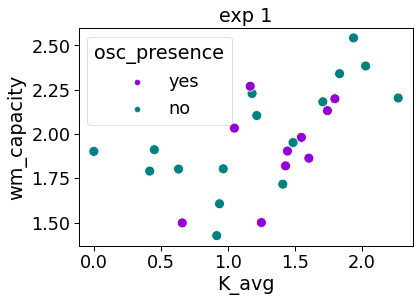

In [207]:
theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}

sns.scatterplot(x='K_avg', y='wm_capacity', hue='osc_presence', data=df_all_theta_diff_avg, palette=theta_no_theta, s=100)
plt.title('exp 1')

In [208]:
# stats for correlation over osc present or not
print(pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['exponent']))
print(pg.corr(x=df_all_theta_bas_avg['K_avg'], y=df_all_theta_bas_avg['exponent']))
print(pg.corr(x=df_all_theta_ret_avg['K_avg'], y=df_all_theta_ret_avg['exponent']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.065438  [-0.44, 0.33]  0.750787  0.255  0.061183
          n         r          CI95%     p-val   BF10     power
pearson  26  0.195152  [-0.21, 0.54]  0.339389  0.375  0.160775
          n         r          CI95%     p-val   BF10     power
pearson  26  0.182998  [-0.22, 0.53]  0.370888  0.356  0.146665


In [209]:
# stats for correlation over osc present or not
print(pg.corr(x=df_all_theta_diff_avg['K_avg'], y=df_all_theta_diff_avg['offset']))
print(pg.corr(x=df_all_theta_bas_avg['K_avg'], y=df_all_theta_bas_avg['offset']))
print(pg.corr(x=df_all_theta_ret_avg['K_avg'], y=df_all_theta_ret_avg['offset']))

          n         r          CI95%     p-val   BF10     power
pearson  26  0.035591  [-0.36, 0.42]  0.862958  0.247  0.052872
          n         r          CI95%     p-val   BF10     power
pearson  26  0.126793  [-0.27, 0.49]  0.537088  0.292  0.094703
          n         r         CI95%     p-val   BF10     power
pearson  26  0.134595  [-0.27, 0.5]  0.512119  0.299  0.100649


Text(0.5, 1.0, 'exp 1')

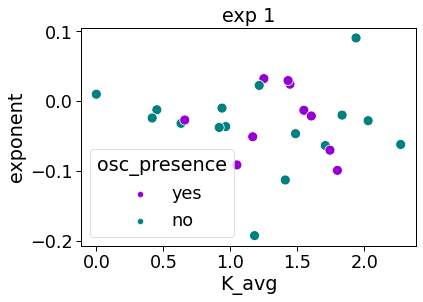

In [210]:
theta_no_theta = {'yes': 'darkviolet',
                'no': 'teal'}

sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_diff_avg, palette=theta_no_theta, s=100)
plt.title('exp 1')

Text(0.5, 1.0, 'exp 1')

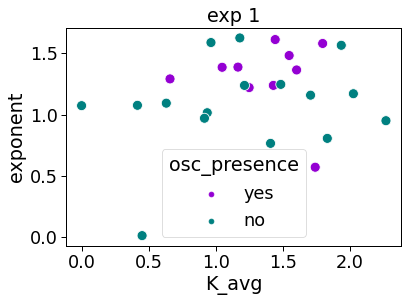

In [211]:
sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_bas_avg, palette=theta_no_theta, s=100)
plt.title('exp 1')

Text(0.5, 1.0, 'exp 1')

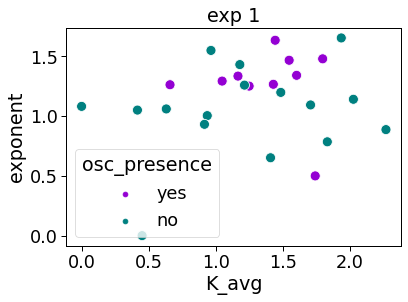

In [212]:
sns.scatterplot(x='K_avg', y='exponent', hue='osc_presence', data=df_all_theta_ret_avg, palette=theta_no_theta, s=100)
plt.title('exp 1')

Is having theta or not related to K-values? --> NO difference in performance on K-values nor on wm capacity on the task

In [213]:
pg.normality(data=df_all_theta_diff_avg, dv='K_avg', group='osc_presence')

,W,pval,normal
yes,0.947813,0.642701,True
no,0.978115,0.946864,True


In [214]:
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='K_avg', group='osc_presence', method='levene')

,W,pval,equal_var
levene,4.414764,0.046313,False


In [215]:
pg.ttest(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['K_avg'],
         y=df_all_theta_diff_avg.query('osc_presence=="no"')['K_avg'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.805725,23.627041,two-sided,0.428437,"[-0.25, 0.56]",0.284221,0.469,0.10397


In [216]:
pg.normality(data=df_all_theta_diff_avg, dv='wm_capacity', group='osc_presence')

,W,pval,normal
yes,0.925952,0.409279,True
no,0.979765,0.961707,True


In [217]:
pg.homoscedasticity(data=df_all_theta_diff_avg, dv='wm_capacity', group='osc_presence', method='levene')

,W,pval,equal_var
levene,0.443847,0.511625,True


In [218]:
pg.ttest(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['wm_capacity'],
         y=df_all_theta_diff_avg.query('osc_presence=="no"')['wm_capacity'])

# pg.mwu(x=df_all_theta_diff_avg.query('osc_presence=="yes"')['wm_capacity'],
#          y=df_all_theta_diff_avg.query('osc_presence=="no"')['wm_capacity'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.648087,21.361319,two-sided,0.523834,"[-0.31, 0.16]",0.252405,0.431,0.092359


### Theta difference between setsize 6 and 1

In [219]:
# Take difference in exponent: setsize 6 - setsize 1
df_theta_avg_diff_avg = df_all_theta_diff.groupby(['sub_id', 'set_size']).mean()
df_theta_avg_diff_avg.head()

ss_diff = (df_theta_avg_diff_avg.query('set_size==6')['exponent'].values - 
        df_theta_avg_diff_avg.query('set_size==1')['exponent'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_all_theta_diff['sub_id'].unique(),
              'exponent_ssdiff': ss_diff})


# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

In [220]:
df_all_theta_diff.head()

,bas_ret_diff,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,diff,1.0,87.944444,1.0,-0.058994,-0.117494,0.056197,0.075229,-4.519774,0.143127,0.753848,0.082482,1.347218,NaN,1.903654,1.0
4,diff,1.0,87.931677,3.0,0.065295,0.028273,-0.019226,-0.214985,0.574713,-0.597461,-1.263486,-0.059916,-1.068501,NaN,1.903654,1.0
7,diff,1.0,90.844720,6.0,0.067170,0.018833,0.137401,0.116333,-12.222222,0.265007,0.973625,0.135152,1.085679,NaN,1.903654,1.0
1,diff,5.0,80.866667,1.0,0.045298,0.037914,-0.111523,-0.273200,7.878788,-1.472705,-3.185633,-0.147716,-3.008832,NaN,1.500000,1.0
4,diff,5.0,77.605442,3.0,0.022843,0.003520,-0.002920,-0.080268,0.000000,-2.022619,-4.502640,-0.133538,-4.174756,NaN,1.500000,1.0


<AxesSubplot:xlabel='K_avg', ylabel='exponent_ssdiff'>

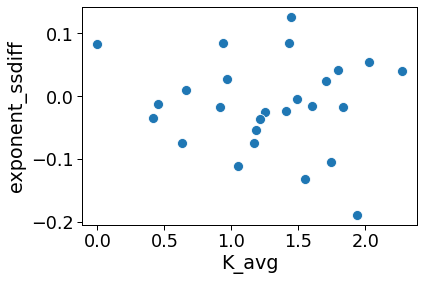

In [221]:
sns.scatterplot(x='K_avg', y='exponent_ssdiff', data=df_ssdiff_k, s=100)

In [222]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['exponent_ssdiff']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.093317  [-0.46, 0.31]  0.650251  0.268  0.073579


#### FRONTAL MIDLINE - EXPONENT BASELINE

In [223]:
df_theta_avg_bas_avg = df_all_theta_bas.groupby(['sub_id']).mean()
# MErge with dataframe that has K information
df_bas_k = pd.merge(df_theta_avg_bas_avg, df_k, how='inner', on='sub_id')

df_bas_k.head()

,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,88.906947,3.333333,1.611323,1.282705,0.255965,6.044472,77.179579,6.922632,14.146230,0.794020,9.980313,0.834471,1.903654,1.0,1.2500,1.250,1.833333,1.444444
1,2.0,56.439331,3.333333,0.013623,0.321173,0.343514,5.412795,63.504554,9.483309,18.882049,0.730767,12.439899,0.499843,1.911252,0.0,0.9375,0.250,0.166667,0.451389
2,3.0,105.213703,3.333333,1.564574,1.365850,0.268959,6.147284,74.241165,10.625433,20.915598,0.889643,15.134572,0.831015,2.542394,0.0,1.4375,2.375,2.000000,1.937500
3,4.0,87.798709,3.333333,1.014972,0.968883,0.279888,5.881267,65.716522,6.100617,12.182616,0.588049,7.359390,0.723977,1.606019,0.0,0.9375,0.875,1.000000,0.937500
4,5.0,77.373056,3.333333,1.219906,1.205780,0.368243,5.849611,62.237971,8.775462,17.636602,0.779986,11.377491,0.689762,1.500000,1.0,1.2500,1.500,1.000000,1.250000


Text(0.5, 1.0, 'Exp1: Average WM capacity (K) ~ baseline fm exponent')

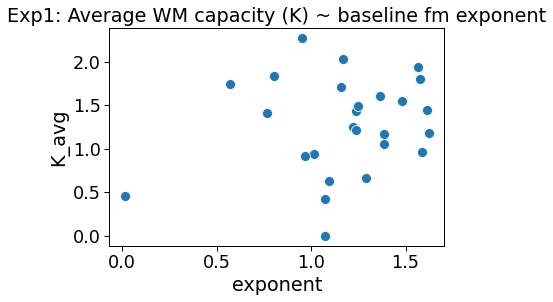

In [224]:
sns.scatterplot(x='exponent', y='K_avg', data=df_bas_k, s=100)
plt.title('Exp1: Average WM capacity (K) ~ baseline fm exponent')

### ALPHA -- occipital (difference)

In [225]:
df_alpha_avg_diff.head()

,lateralization,bas_ret_diff,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
1,contra,diff,1.0,93.051948,1.0,0.028525,-0.047891,-0.125046,0.086155,4.519774,-4.440927,-16.648935,-0.154460,-14.860490,NaN,1.903654,1.0
4,ipsi,diff,1.0,93.051948,1.0,-0.038647,-0.106407,-0.059296,-0.001724,2.824859,-3.508912,-11.748614,-0.188172,-10.409327,NaN,1.903654,1.0
7,contra,diff,1.0,89.078947,3.0,-0.089863,-0.189019,-0.286964,0.075506,3.448276,-10.707609,-44.450598,-0.715603,-40.086361,NaN,1.903654,1.0
10,ipsi,diff,1.0,89.078947,3.0,-0.008553,-0.124246,-0.312055,-0.020907,5.172414,-10.828574,-45.010146,-0.775858,-40.445172,NaN,1.903654,1.0
13,contra,diff,1.0,91.698718,6.0,-0.040258,-0.144573,-0.313119,0.253830,2.777778,-10.951253,-43.710774,-0.699319,-39.374449,NaN,1.903654,1.0


In [226]:
# Take difference in exponent: setsize 6 - setsize 1
df_alpha_avg_diff_avg = df_alpha_avg_diff.groupby(['sub_id', 'set_size']).mean()
df_alpha_avg_diff_avg.head()

trial_n  exponent    offset     power        cf  peak_perc  \
sub_id set_size                                                                 
1.0    1.0       93.051948 -0.005061 -0.077149 -0.092171  0.042216   3.672316   
       3.0       89.078947 -0.049208 -0.156633 -0.299509  0.027300   4.310345   
       6.0       91.698718 -0.035495 -0.143888 -0.312194  0.235240   2.777778   
2.0    1.0       56.095745 -0.085186 -0.122397 -0.176187  0.155570   9.090909   
       3.0       58.434783 -0.033540 -0.066311 -0.198247 -0.031376   9.909910   

                 bandpower        auc  auc_log_osc  auc_lin_osc  r2s  \
sub_id set_size                                                        
1.0    1.0       -3.974920 -14.198775    -0.171316   -12.634908  NaN   
       3.0      -10.768092 -44.730372    -0.745730   -40.265767  NaN   
       6.0      -11.609040 -46.697550    -0.779361   -42.089010  NaN   
2.0    1.0       -2.790956 -11.337271    -0.469727   -10.059584  NaN   
       3.0       -2.169387  -9.356902    -0.518090    -8.341007  NaN   

                 wm_capacity  osc_presence  
sub_id set_size                             
1.0    1.0          1.903654           1.0  
       3.0          1.903654           1.0  
       6.0          1.903654           1.0  
2.0    1.0          1.911252           1.0  
       3.0          1.911252           1.0

In [227]:
ss_diff = (df_alpha_avg_diff_avg.query('set_size==6')['exponent'].values - 
        df_alpha_avg_diff_avg.query('set_size==1')['exponent'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_alpha_avg_diff['sub_id'].unique(),
              'exponent_ssdiff': ss_diff})

# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

<AxesSubplot:xlabel='K_avg', ylabel='exponent_ssdiff'>

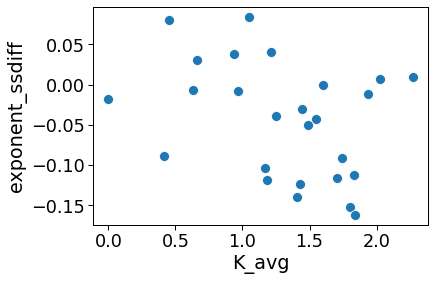

In [228]:
sns.scatterplot(x='K_avg', y='exponent_ssdiff', data=df_ssdiff_k, s=100)


In [229]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['exponent_ssdiff']))

          n        r          CI95%     p-val   BF10     power
pearson  26 -0.34081  [-0.64, 0.05]  0.088424  0.965  0.409252


### ALPHA -- occipital (baseline)

In [230]:
df_all_alpha_diff_avg = df_alpha_avg_diff.groupby('sub_id').mean()
df_all_alpha_bas_avg = df_alpha_avg_bas.groupby('sub_id').mean()
df_all_alpha_ret_avg = df_alpha_avg_ret.groupby('sub_id').mean()

In [231]:
# Combine K with other dataframe that has exponent
df_all_alpha_diff_avg = pd.merge(df_all_alpha_diff_avg, df_k, how='inner', on='sub_id')
df_all_alpha_bas_avg = pd.merge(df_all_alpha_bas_avg, df_k, how='inner', on='sub_id')
df_all_alpha_ret_avg = pd.merge(df_all_alpha_ret_avg, df_k, how='inner', on='sub_id')

In [232]:
# Calculate average exponent regardless of hemisphere or set-size condition
df_alpha_avg_bas_avg = df_alpha_avg_bas.groupby(['sub_id']).mean()
df_alpha_avg_bas_avg.head()

,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence
sub_id,,,,,,,,,,,,,,
1.0,91.276538,3.333333,1.549387,1.096007,1.657650,9.498638,3.945981,17.043041,69.810576,4.625847,61.954026,0.846985,1.903654,1.0
2.0,57.219326,3.333333,1.302188,1.063095,0.855265,9.983917,23.378413,5.295419,22.274021,2.293759,17.839764,0.744326,1.911252,1.0
3.0,105.560701,3.333333,1.182947,0.810587,0.857721,9.314421,22.330202,4.278498,15.649985,2.319655,12.497419,0.810506,2.542394,1.0
4.0,90.667135,3.333333,1.617695,1.060883,1.840042,10.304616,0.365164,11.662962,55.321090,5.017597,49.152466,0.848729,1.606019,1.0
5.0,77.809646,3.333333,0.542945,0.349830,0.809761,10.556709,28.093206,3.817381,15.966453,2.039136,11.811027,0.515088,1.500000,1.0


In [233]:
print(pg.corr(x=df_all_alpha_diff_avg['wm_capacity'], y=df_all_alpha_diff_avg['exponent']))
print(pg.corr(x=df_all_alpha_bas_avg['wm_capacity'], y=df_all_alpha_bas_avg['exponent']))
print(pg.corr(x=df_all_alpha_ret_avg['wm_capacity'], y=df_all_alpha_ret_avg['exponent']))

          n         r           CI95%     p-val   BF10     power
pearson  26 -0.411081  [-0.69, -0.03]  0.036954  1.918  0.567431
          n         r         CI95%     p-val   BF10     power
pearson  26  0.014212  [-0.38, 0.4]  0.945065  0.244  0.049964
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.070658  [-0.45, 0.33]  0.731602  0.257  0.063157


Text(0.5, 1.0, 'Occipital exponent difference (ret-bas) - averaged over set-sizes')

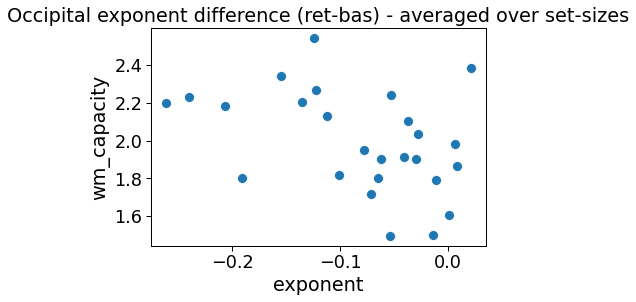

In [234]:
sns.scatterplot(x='exponent', y='wm_capacity', data=df_all_alpha_diff_avg, s=100)
plt.title('Occipital exponent difference (ret-bas) - averaged over set-sizes')

In [235]:
print(pg.corr(x=df_all_alpha_diff_avg['wm_capacity'], y=df_all_alpha_diff_avg['offset']))
print(pg.corr(x=df_all_alpha_bas_avg['wm_capacity'], y=df_all_alpha_bas_avg['offset']))
print(pg.corr(x=df_all_alpha_ret_avg['wm_capacity'], y=df_all_alpha_ret_avg['offset']))

          n         r          CI95%     p-val   BF10    power
pearson  26 -0.315292  [-0.63, 0.08]  0.116663  0.783  0.35612
          n         r          CI95%     p-val   BF10     power
pearson  26  0.039451  [-0.35, 0.42]  0.848256  0.248  0.053665
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.034338  [-0.42, 0.36]  0.867743  0.247  0.052632


In [236]:
print(pg.corr(x=df_all_alpha_diff_avg['K_avg'], y=df_all_alpha_diff_avg['exponent']))
print(pg.corr(x=df_all_alpha_bas_avg['K_avg'], y=df_all_alpha_bas_avg['exponent']))
print(pg.corr(x=df_all_alpha_ret_avg['K_avg'], y=df_all_alpha_ret_avg['exponent']))

          n         r         CI95%     p-val   BF10     power
pearson  26 -0.207163  [-0.55, 0.2]  0.309892  0.397  0.175756
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.051035  [-0.43, 0.34]  0.804451  0.251  0.056545
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.091906  [-0.46, 0.31]  0.655216  0.268  0.072841


In [237]:
print(pg.corr(x=df_all_alpha_diff_avg['K_avg'], y=df_all_alpha_diff_avg['offset']))
print(pg.corr(x=df_all_alpha_bas_avg['K_avg'], y=df_all_alpha_bas_avg['offset']))
print(pg.corr(x=df_all_alpha_ret_avg['K_avg'], y=df_all_alpha_ret_avg['offset']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.117799  [-0.48, 0.28]  0.566563  0.285  0.088336
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.059133  [-0.44, 0.34]  0.774155  0.253  0.059007
          n         r          CI95%     p-val   BF10     power
pearson  26 -0.086466  [-0.46, 0.31]  0.674487  0.265  0.070107


In [238]:
# MErge with dataframe that has K information
df_bas_k = pd.merge(df_alpha_avg_bas_avg, df_k, how='inner', on='sub_id')
df_bas_k.head()

,sub_id,trial_n,set_size,exponent,offset,power,cf,peak_perc,bandpower,auc,auc_log_osc,auc_lin_osc,r2s,wm_capacity,osc_presence,K_3,K_6,K_8,K_avg
0,1.0,91.276538,3.333333,1.549387,1.096007,1.657650,9.498638,3.945981,17.043041,69.810576,4.625847,61.954026,0.846985,1.903654,1.0,1.2500,1.250,1.833333,1.444444
1,2.0,57.219326,3.333333,1.302188,1.063095,0.855265,9.983917,23.378413,5.295419,22.274021,2.293759,17.839764,0.744326,1.911252,1.0,0.9375,0.250,0.166667,0.451389
2,3.0,105.560701,3.333333,1.182947,0.810587,0.857721,9.314421,22.330202,4.278498,15.649985,2.319655,12.497419,0.810506,2.542394,1.0,1.4375,2.375,2.000000,1.937500
3,4.0,90.667135,3.333333,1.617695,1.060883,1.840042,10.304616,0.365164,11.662962,55.321090,5.017597,49.152466,0.848729,1.606019,1.0,0.9375,0.875,1.000000,0.937500
4,5.0,77.809646,3.333333,0.542945,0.349830,0.809761,10.556709,28.093206,3.817381,15.966453,2.039136,11.811027,0.515088,1.500000,1.0,1.2500,1.500,1.000000,1.250000


Text(0.5, 1.0, 'Exp1: Average WM capacity (K) ~ baseline occipital exponent')

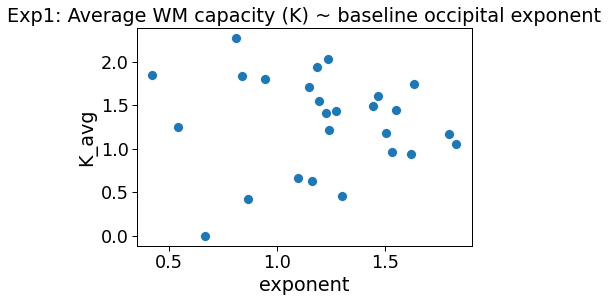

In [239]:
sns.scatterplot(x='exponent', y='K_avg', data=df_bas_k, s=100)
plt.title('Exp1: Average WM capacity (K) ~ baseline occipital exponent')

In [240]:
# sns.scatterplot(x='exponent', y='K_avg', data=df_bas_k, s=100)
# plt.title('Average WM capacity (K) correlated with baseline exponent')

In [241]:
print(pg.corr(x=df_bas_k['K_avg'], y=df_bas_k['exponent']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.051035  [-0.43, 0.34]  0.804451  0.251  0.056545


#### What about relative alpha power?

In [242]:
df_alpha_avg_diff_avg.head()


trial_n  exponent    offset     power        cf  peak_perc  \
sub_id set_size                                                                 
1.0    1.0       93.051948 -0.005061 -0.077149 -0.092171  0.042216   3.672316   
       3.0       89.078947 -0.049208 -0.156633 -0.299509  0.027300   4.310345   
       6.0       91.698718 -0.035495 -0.143888 -0.312194  0.235240   2.777778   
2.0    1.0       56.095745 -0.085186 -0.122397 -0.176187  0.155570   9.090909   
       3.0       58.434783 -0.033540 -0.066311 -0.198247 -0.031376   9.909910   

                 bandpower        auc  auc_log_osc  auc_lin_osc  r2s  \
sub_id set_size                                                        
1.0    1.0       -3.974920 -14.198775    -0.171316   -12.634908  NaN   
       3.0      -10.768092 -44.730372    -0.745730   -40.265767  NaN   
       6.0      -11.609040 -46.697550    -0.779361   -42.089010  NaN   
2.0    1.0       -2.790956 -11.337271    -0.469727   -10.059584  NaN   
       3.0       -2.169387  -9.356902    -0.518090    -8.341007  NaN   

                 wm_capacity  osc_presence  
sub_id set_size                             
1.0    1.0          1.903654           1.0  
       3.0          1.903654           1.0  
       6.0          1.903654           1.0  
2.0    1.0          1.911252           1.0  
       3.0          1.911252           1.0

In [243]:
ss_diff = (df_alpha_avg_diff_avg.query('set_size==6')['power'].values - 
        df_alpha_avg_diff_avg.query('set_size==1')['power'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_alpha_avg_diff['sub_id'].unique(),
              'rel_power_ssdiff': ss_diff})

# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

<AxesSubplot:xlabel='K_avg', ylabel='rel_power_ssdiff'>

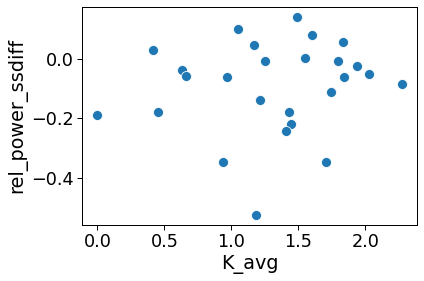

In [244]:
sns.scatterplot(x='K_avg', y='rel_power_ssdiff', data=df_ssdiff_k, s=100)

In [245]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['rel_power_ssdiff']))

          n         r          CI95%    p-val   BF10     power
pearson  26  0.129914  [-0.27, 0.49]  0.52703  0.294  0.097035


#### What about bandpower?

In [246]:
ss_diff = (df_alpha_avg_diff_avg.query('set_size==6')['bandpower'].values - 
        df_alpha_avg_diff_avg.query('set_size==1')['bandpower'].values)

# Create DF with exponent diffreence of setsize 6 - 1
df_ssdiff = pd.DataFrame({'sub_id': df_alpha_avg_diff['sub_id'].unique(),
              'bandpower_ssdiff': ss_diff})

# MErge with dataframe that has K information
df_ssdiff_k = pd.merge(df_ssdiff, df_k, how='inner', on='sub_id')

<AxesSubplot:xlabel='K_avg', ylabel='bandpower_ssdiff'>

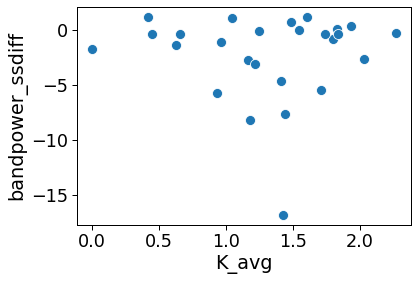

In [247]:
sns.scatterplot(x='K_avg', y='bandpower_ssdiff', data=df_ssdiff_k, s=100)

In [248]:
print(pg.corr(x=df_ssdiff_k['K_avg'], y=df_ssdiff_k['bandpower_ssdiff']))

          n         r          CI95%     p-val   BF10     power
pearson  26 -0.022776  [-0.41, 0.37]  0.912063  0.245  0.050828
